In [1]:
import numpy as np
import pandas as pd

import torch
import torch.fft as fft
import matplotlib.pyplot as plt

import xarray as xr

import seaborn as sns
from mpl_toolkits.basemap import Basemap


import cartopy.crs as ccrs
import cartopy.feature as cfeature



/home/mila/s/sebastian.hickman/.conda/envs/env_emulator_conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mila/s/sebastian.hickman/.conda/envs/env_emulator_conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Read in some observations, some reconstruction and some predictions from the model:

# /home/mila/s/sebastian.hickman/scratch/results/test_multigpu/var_['ts']_scenarios_piControl_tau_2_z_90_lr_0.001_spreg_0.99998_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False/train_x_ar_0.npy

# read it in

obs_x_data = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_x_ar_0.npy")
obs_y_data = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_y_ar_0.npy")
recons_y_data = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/y_pred_recons_train.npy")
pred_y_data = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_y_pred_ar_0.npy")


In [3]:
obs_y_data.shape

(64, 4, 6250)

In [4]:
# read in some icosahedral coordinates .txt file

icosahedral_coords = np.loadtxt("/home/mila/s/sebastian.hickman/work/causalpaca/causal/vertex_lonlat_mapping.txt")

In [5]:
icosahedral_coords

array([[ 1.00000e+00,  0.00000e+00,  9.00000e+01],
       [ 2.00000e+00, -3.60000e+01,  8.73569e+01],
       [ 3.00000e+00, -3.60000e+01,  8.47138e+01],
       ...,
       [ 6.24800e+03, -3.26457e+01,  2.22497e+01],
       [ 6.24900e+03, -3.42942e+01,  2.44166e+01],
       [ 6.25000e+03, -3.60000e+01,  2.65651e+01]])

In [6]:
# Read the icosahedral coordinates from the text file
# Separate the coordinates into latitude and longitude
latitudes = icosahedral_coords[:, 2]
longitudes = icosahedral_coords[:, 1]

In [7]:
longitudes.max()

180.0

In [8]:
# Create an xarray.Dataset with latitude and longitude as coordinates
ds = xr.Dataset(
    coords={
        'lat': (['points'], latitudes),
        'lon': (['points'], longitudes)
    }
)

In [9]:
ds

<xarray.Dataset>
Dimensions:  (points: 6250)
Coordinates:
    lat      (points) float64 90.0 87.36 84.71 82.07 ... 20.07 22.25 24.42 26.57
    lon      (points) float64 0.0 -36.0 -36.0 -36.0 ... -32.65 -34.29 -36.0
Dimensions without coordinates: points
Data variables:
    *empty*

In [10]:
# Add the data to the dataset
ds['data'] = (['points'], obs_y_data[0, 3, :])

ds

<xarray.Dataset>
Dimensions:  (points: 6250)
Coordinates:
    lat      (points) float64 90.0 87.36 84.71 82.07 ... 20.07 22.25 24.42 26.57
    lon      (points) float64 0.0 -36.0 -36.0 -36.0 ... -32.65 -34.29 -36.0
Dimensions without coordinates: points
Data variables:
    data     (points) float32 -1.035 -1.249 -0.5828 ... 0.891 0.2025 1.144

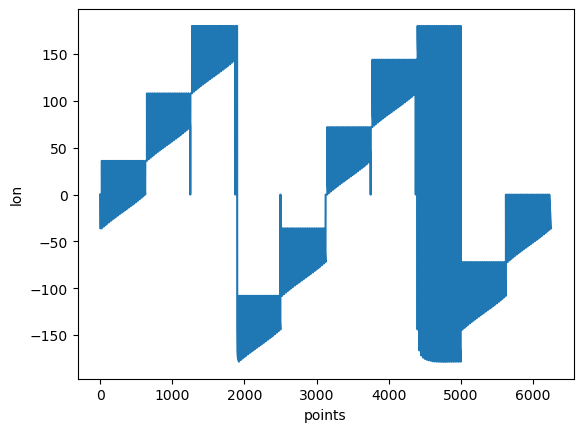

In [11]:
# plot this data on a map using the lat and lon coordinates

ds['lon'].plot()

Text(0.5, 1.0, 'Ground-truth t-1')

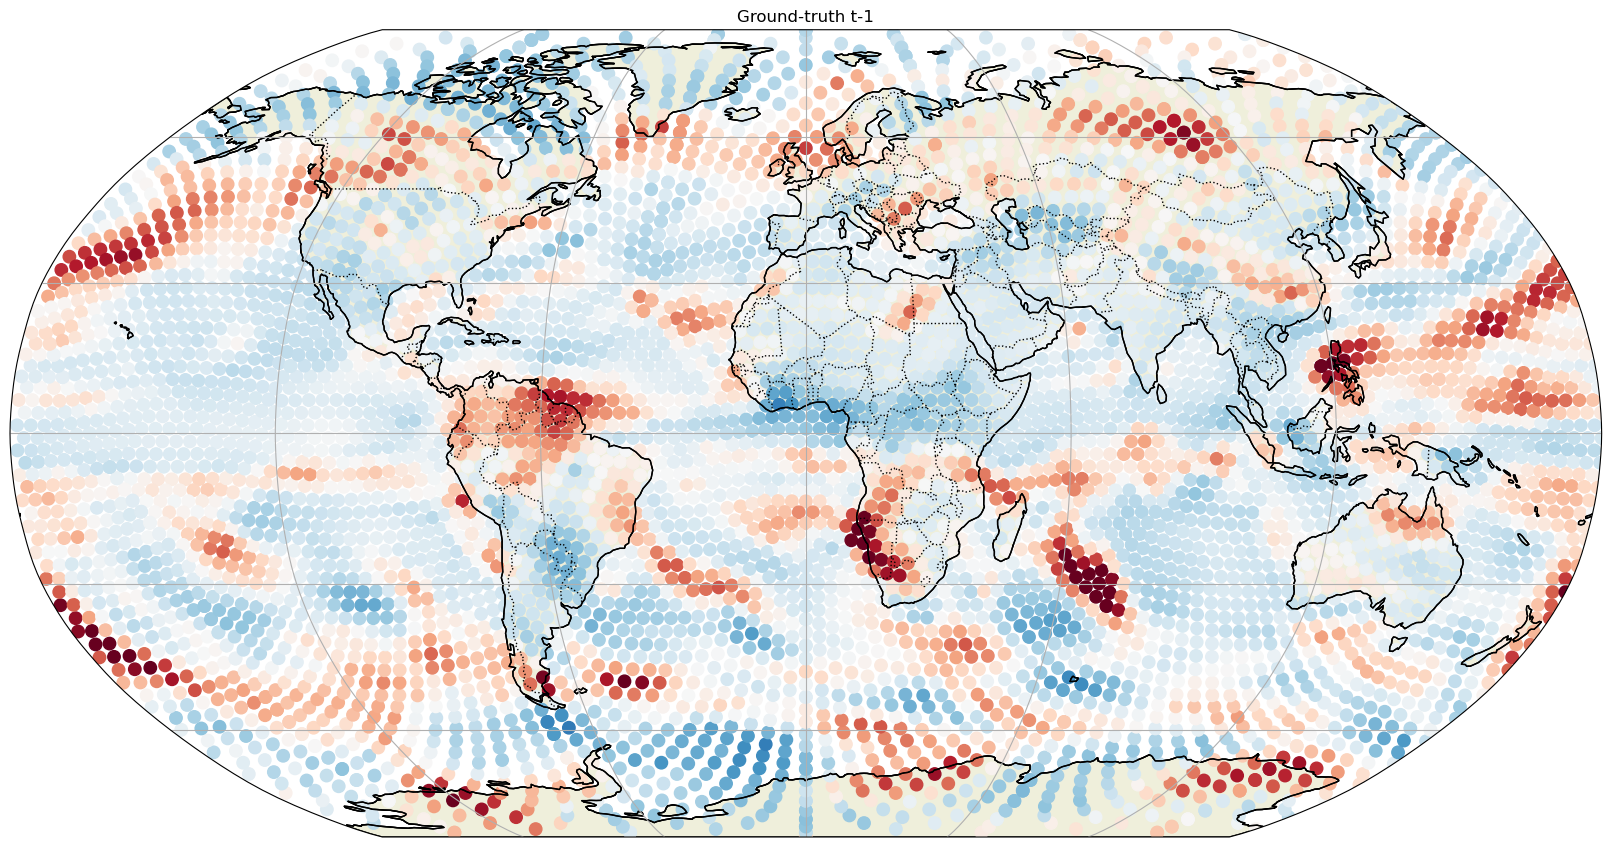

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()}, layout='constrained', figsize=(16, 12))

ax.set_global()
ax.coastlines()
# Add some map features for context
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.gridlines(draw_labels=False)

# Unpack coordinates for vectorized scatter plot
# something like lonlat_vertex_mapping.txt
lon = ds['lon']
lat = ds['lat']



#print('x_past shape:', x_past.shape)
s = ax.scatter(x=lon, y=lat, c=ds['data'], alpha=1, s=80, vmin=-3.5, vmax=3.5, cmap="RdBu_r", transform=ccrs.PlateCarree())
ax.set_title("Ground-truth t-1")

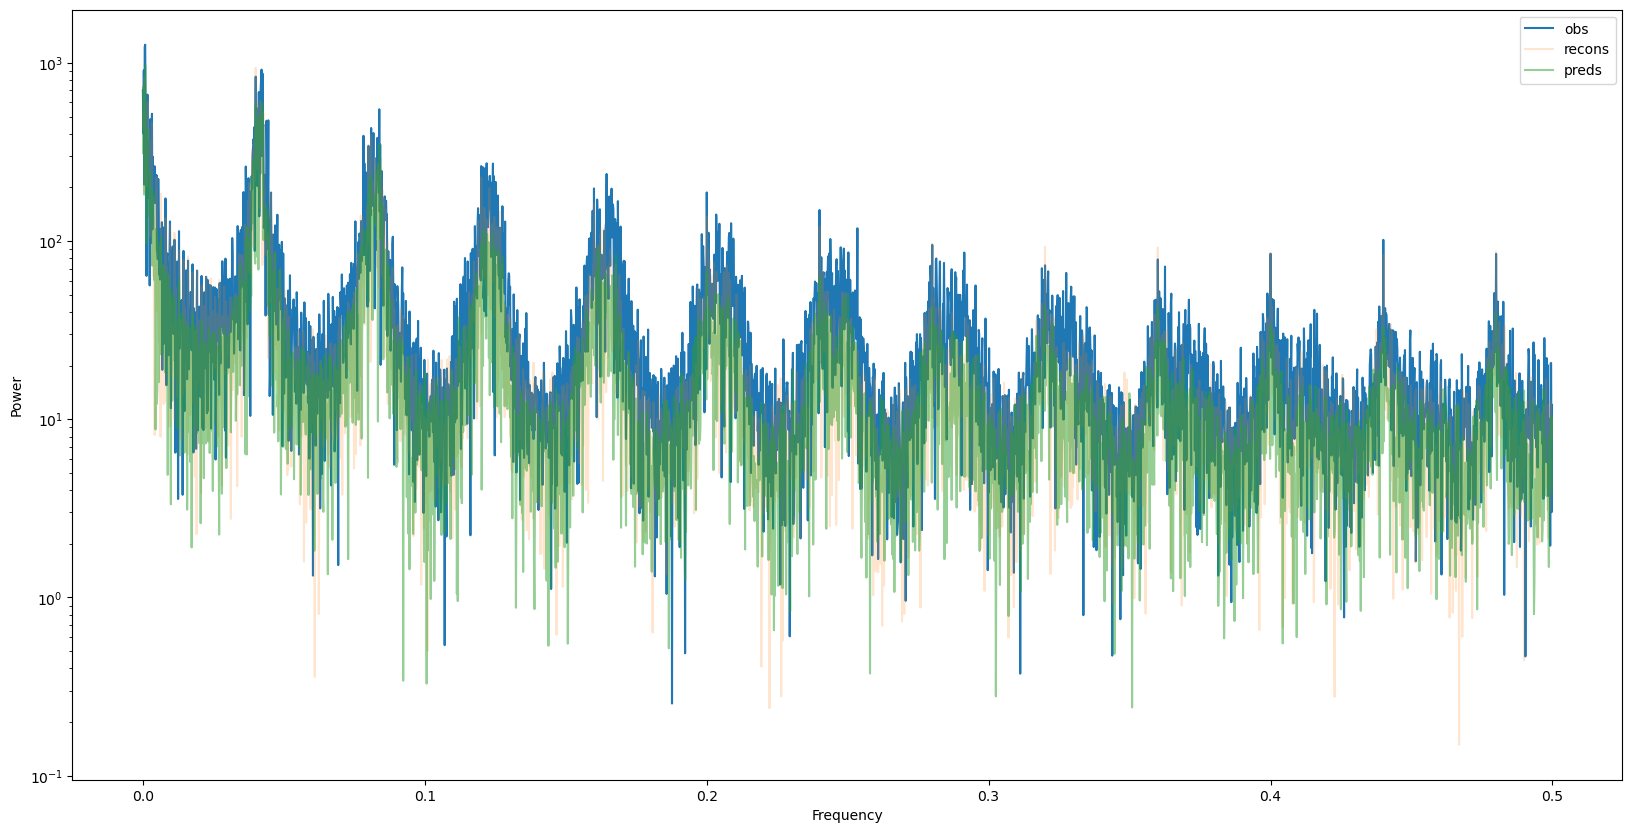

In [7]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 0, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 0, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 0, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [8]:
# calculate the distance between the power spectra

fft_true = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, :, :]), dim=2)), dim=0)
        
# calculate the spectra of the predicted values
fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, :, :]), dim=2)), dim=0)
        
# Calculate the power spectrum
spectral_loss = torch.mean(torch.abs(fft_pred - fft_true))

spectral_loss

tensor(18.7322)

Do this on regular grid actual data

In [92]:
ts_data = xr.open_dataset("/home/mila/s/sebastian.hickman/scratch/data/regular_data/structured/picontrol/outputs/CMIP6/NorESM2-LM/r1i1p1f1/piControl/ts/1600/CMIP6_NorESM2-LM_r1i1p1f1_piControl_ts_250_km_day_gn_1600.nc")
pr_data = xr.open_dataset("/home/mila/s/sebastian.hickman/scratch/data/regular_data/structured/picontrol/outputs/CMIP6/NorESM2-LM/r1i1p1f1/piControl/pr/1600/CMIP6_NorESM2-LM_r1i1p1f1_piControl_pr_250_km_mon_gn_1600.nc")
psl_data = xr.open_dataset("/home/mila/s/sebastian.hickman/scratch/data/regular_data/structured/picontrol/outputs/CMIP6/NorESM2-LM/r1i1p1f1/piControl/psl/1600/CMIP6_NorESM2-LM_r1i1p1f1_piControl_psl_250_km_mon_gn_1600.nc")

In [93]:
# select the first time step

ts_data = ts_data.isel(time=0)
pr_data = pr_data.isel(time=0)
psl_data = psl_data.isel(time=0)

Text(0.5, 1.0, 'Observed data')

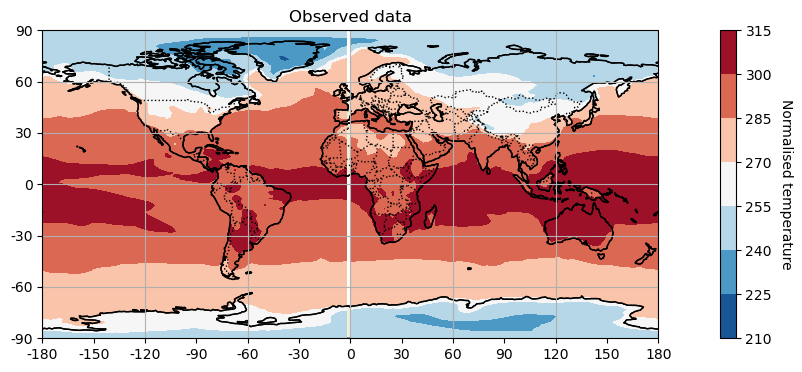

In [94]:
longitudes, latitudes = np.unique(ts_data.lon), np.unique(ts_data.lat)

# set options for the colourbar
#vmin, vmax = -3.5, 3.5  # Minimum and maximum values for colorbar
# Define number of color levels (adjust based on your colormap)

# Create a figure with specified size and axis with a map projection
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 4))

# Add some map features for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

c = ax.contourf(longitudes, latitudes, ts_data.ts, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# Add a colorbar to the map
cbar = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label('Normalised temperature', rotation=270, labelpad=15)

# Label the axes with latitude and longitude values
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.arange(-180, 181, 30))
ax.set_yticklabels(np.arange(-90, 91, 30))
ax.gridlines(draw_labels=False)
# set title
ax.set_title('Observed data')

Text(0.5, 1.0, 'Observed data')

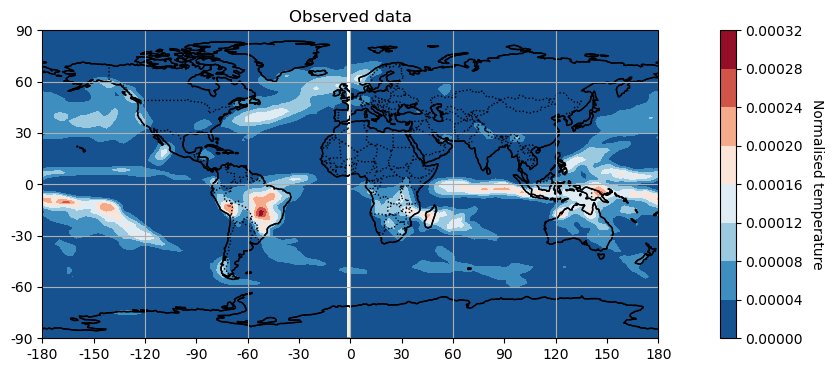

In [95]:
longitudes, latitudes = np.unique(pr_data.lon), np.unique(pr_data.lat)

# set options for the colourbar
#vmin, vmax = -3.5, 3.5  # Minimum and maximum values for colorbar
# Define number of color levels (adjust based on your colormap)

# Create a figure with specified size and axis with a map projection
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 4))

# Add some map features for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

c = ax.contourf(longitudes, latitudes, pr_data.pr, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# Add a colorbar to the map
cbar = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label('Normalised temperature', rotation=270, labelpad=15)

# Label the axes with latitude and longitude values
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.arange(-180, 181, 30))
ax.set_yticklabels(np.arange(-90, 91, 30))
ax.gridlines(draw_labels=False)
# set title
ax.set_title('Observed data')

Text(0.5, 1.0, 'Observed data')

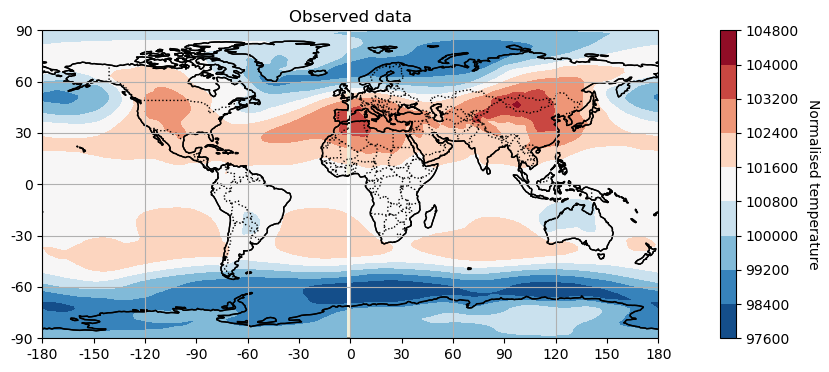

In [96]:
longitudes, latitudes = np.unique(psl_data.lon), np.unique(psl_data.lat)

# set options for the colourbar
#vmin, vmax = -3.5, 3.5  # Minimum and maximum values for colorbar
# Define number of color levels (adjust based on your colormap)

# Create a figure with specified size and axis with a map pslojection
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 4))

# Add some map features for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

c = ax.contourf(longitudes, latitudes, psl_data.psl, transform=ccrs.PlateCarree(), cmap='RdBu_r')
# Add a colorbar to the map
cbar = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label('Normalised temperature', rotation=270, labelpad=15)

# Label the axes with latitude and longitude values
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.arange(-180, 181, 30))
ax.set_yticklabels(np.arange(-90, 91, 30))
ax.gridlines(draw_labels=False)
# set title
ax.set_title('Observed data')

In [97]:
# then extract the values

ts_data = ts_data['ts'].values
pr_data = pr_data['pr'].values
psl_data = psl_data['psl'].values

torch.Size([73])
torch.Size([73])


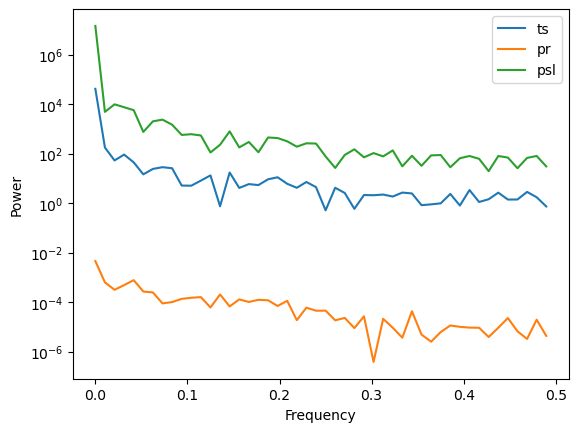

In [101]:
# take the FFT of the data

fft_result_ts = torch.mean(torch.fft.rfft(torch.tensor(ts_data[5:64, :])), axis=0)
fft_result_pr = torch.mean(torch.fft.rfft(torch.tensor(pr_data[5:64, :])), axis=0)
fft_result_psl = torch.mean(torch.fft.rfft(torch.tensor(psl_data[5:64, :])), axis=0)

print(fft_result_ts.shape)
print(fft_result_pr.shape)

# Calculate the power spectrum
power_spectrum_ts = torch.abs(fft_result_ts)
power_spectrum_pr = torch.abs(fft_result_pr)
power_spectrum_psl = torch.abs(fft_result_psl)

# Obtain frequency bins
freq = torch.fft.fftfreq(ts_data.shape[0])

# Plot the power spectrum
plt.plot(freq[:int((ts_data.shape[0]/2))], power_spectrum_ts[:int((ts_data.shape[0]/2))], label='ts')
plt.plot(freq[:int((pr_data.shape[0]/2))], power_spectrum_pr[:int((pr_data.shape[0]/2))], label='pr')
plt.plot(freq[:int((psl_data.shape[0]/2))], power_spectrum_psl[:int((psl_data.shape[0]/2))], label='psl')

plt.xlabel('Frequency')
plt.ylabel('Power')
# fix the y axis
plt.yscale('log')
plt.legend()
plt.show()

# Now do this to look at whether the spectra of regular data are closer together when we penalise difference in the spectra

In [ ]:
/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10

In [4]:
# here we did not penalise the spectrum

y_true_train_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/train_y_ar_0.npy")
y_true_val_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/val_y_ar_0.npy")

y_pred_train_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/train_y_pred_ar_0.npy")
y_pred_val_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/val_y_pred_ar_0.npy")

y_recons_train_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/train_y_recons_0.npy")
y_recons_val_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_0/val_y_recons_0.npy")

In [5]:
# here we did not penalise the spectrum

y_true_train_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/train_y_ar_0.npy")
y_true_val_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/val_y_ar_0.npy")

y_pred_train_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/train_y_pred_ar_0.npy")
y_pred_val_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/val_y_pred_ar_0.npy")

y_recons_train_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/train_y_recons_0.npy")
y_recons_val_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_1/val_y_recons_0.npy")

In [6]:
# here we substantially penalised the spectrum!

y_true_train_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/train_y_ar_0.npy")
y_true_val_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/val_y_ar_0.npy")

y_pred_train_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/train_y_pred_ar_0.npy")
y_pred_val_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/val_y_pred_ar_0.npy")

y_recons_train_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/train_y_recons_0.npy")
y_recons_val_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral_regular/var_['ts', 'pr']_scenarios_piControl_tau_2_z_50_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_0_spcoef_10/val_y_recons_0.npy")

In [7]:
# reshape all of these

y_true_train_0 = y_true_train_0.reshape(32, 2, 96, 144)
y_true_val_0 = y_true_val_0.reshape(32, 2, 96, 144)

y_pred_train_0 = y_pred_train_0.reshape(32, 2, 96, 144)
y_pred_val_0 = y_pred_val_0.reshape(32, 2, 96, 144)

y_recons_train_0 = y_recons_train_0.reshape(32, 2, 96, 144)
y_recons_val_0 = y_recons_val_0.reshape(32, 2, 96, 144)

# reshape all of these

y_true_train_1 = y_true_train_1.reshape(32, 2, 96, 144)
y_true_val_1 = y_true_val_1.reshape(32, 2, 96, 144)

y_pred_train_1 = y_pred_train_1.reshape(32, 2, 96, 144)
y_pred_val_1 = y_pred_val_1.reshape(32, 2, 96, 144)

y_recons_train_1 = y_recons_train_1.reshape(32, 2, 96, 144)
y_recons_val_1 = y_recons_val_1.reshape(32, 2, 96, 144)

# reshape all of these

y_true_train_10 = y_true_train_10.reshape(32, 2, 96, 144)
y_true_val_10 = y_true_val_10.reshape(32, 2, 96, 144)

y_pred_train_10 = y_pred_train_10.reshape(32, 2, 96, 144)
y_pred_val_10 = y_pred_val_10.reshape(32, 2, 96, 144)

y_recons_train_10 = y_recons_train_10.reshape(32, 2, 96, 144)
y_recons_val_10 = y_recons_val_10.reshape(32, 2, 96, 144)

In [9]:
out_fft_0 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_0[:, 1, :, :]), dim=2)),dim=0)
recons_fft_0 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_0[:, 1, :, :]), dim=2)),dim=0)
target_fft_0 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_0[:, 1, :, :]), dim=2)),dim=0)

out_fft_1 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_1[:, 1, :, :]), dim=2)),dim=0)
recons_fft_1 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_1[:, 1, :, :]), dim=2)),dim=0)
target_fft_1 = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_1[:, 1, :, :]), dim=2)),dim=0)

out_fft = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_10[:, 1, :, :]), dim=2)),dim=0)
recons_fft = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_10[:, 1, :, :]), dim=2)),dim=0)
target_fft = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_10[:, 1, :, :]), dim=2)),dim=0)

out_fft_0_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_0[:, 0, :, :]), dim=2)),dim=0)
recons_fft_0_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_0[:, 0, :, :]), dim=2)),dim=0)
target_fft_0_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_0[:, 0, :, :]), dim=2)),dim=0)

out_fft_1_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_1[:, 0, :, :]), dim=2)),dim=0)
recons_fft_1_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_1[:, 0, :, :]), dim=2)),dim=0)
target_fft_1_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_1[:, 0, :, :]), dim=2)),dim=0)

out_fft_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_true_train_10[:, 0, :, :]), dim=2)),dim=0)
recons_fft_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_recons_train_10[:, 0, :, :]), dim=2)),dim=0)
target_fft_ts = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(y_pred_train_10[:, 0, :, :]), dim=2)),dim=0)

# Calculate the power spectrum


print(torch.mean(torch.abs(out_fft - recons_fft)))
print(torch.mean(torch.abs(out_fft - target_fft)))

tensor(3.4624)
tensor(1.3490)


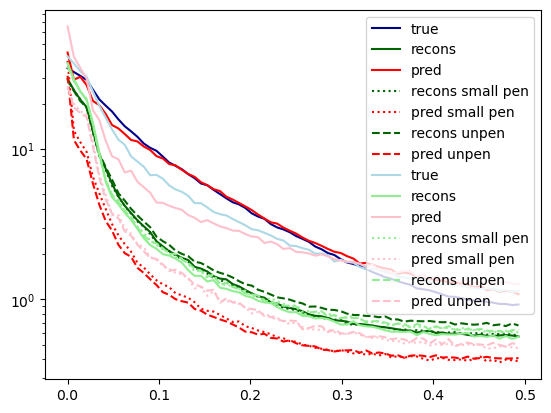

In [13]:
# plot the spectra

# Calculate the power spectrum

# Obtain frequency bins
freq = torch.fft.fftfreq(y_true_train_0.shape[3])


# PRECIPITATION
# Plot the power spectrum 
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true', color='darkblue')
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons', color='darkgreen')
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred', color='red')

# Plot the power spectrum 
#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft_1, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true small pen', color='darkblue', linestyle=":")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft_1, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons small pen', color='darkgreen', linestyle=":")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft_1, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred small pen', color='red', linestyle=":")

# Plot the power spectrum 
#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft_0, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true unpen', color='darkblue', linestyle="--")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft_0, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons unpen', color='darkgreen', linestyle="--")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft_0, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred unpen', color='red', linestyle="--")

# TEMPERATURE
# Plot the power spectrum 
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true', color='lightblue')
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons', color='lightgreen')
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred', color='pink')

# Plot the power spectrum 
#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft_1_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true small pen', color='lightblue', linestyle=":")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft_1_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons small pen', color='lightgreen', linestyle=":")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft_1_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred small pen', color='pink', linestyle=":")

# Plot the power spectrum 
#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(out_fft_0_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='true unpen', color='lightblue', linestyle="--")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(recons_fft_0_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='recons unpen', color='lightgreen', linestyle="--")
plt.plot(freq[:int((y_true_train_0.shape[3]/2))], torch.mean(target_fft_0_ts, axis=0)[:int(y_true_train_0.shape[3]/2)], label='pred unpen', color='pink', linestyle="--")


#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], recons_fft[:int((y_true_train_0.shape[2]/2))], label='recons')
#plt.plot(freq[:int((y_true_train_0.shape[3]/2))], target_fft[:int((y_true_train_0.shape[2]/2))], label='target')

# make it a log scale on the y axis

plt.yscale('log')

plt.legend()

# Great. It looks like the spectrum is being penalised appropriately.

In [ ]:
# Read in some of the 

In [48]:
lat_index = np.r_[7:15, 32:40]
# lat_index = np.r_[0:48]
#quad_weight_reg = quad_weights.reshape(1,1,48,1)[:,:,lat_index,:]

out_fft = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(ts_data[lat_index,:]),dim=1)),dim=0)
target_fft = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pr_data[lat_index,:]),dim=1)),dim=0)



# wave_weight = torch.arange(48).reshape(1,1,48).to(device)
#wave_index = np.r_[0:48]
#wave_index = np.r_[7:15,32:40]
#loss_fft = torch.abs(out_fft[:,:,wave_index]-target_fft[:,:,wave_index])# * cos_weight_reg

#loss_reg = torch.mean(loss_fft[...,:]) 



print(torch.abs(out_fft - target_fft))
print(torch.mean(torch.abs(out_fft - target_fft)))

tensor([4.0731e+04, 4.1054e+02, 1.4005e+02, 1.5772e+02, 1.4708e+02, 5.1051e+01,
        7.0610e+01, 8.6617e+01, 6.6107e+01, 5.9967e+01, 5.8601e+01, 2.5502e+01,
        3.8512e+01, 2.3792e+01, 4.2384e+01, 3.0299e+01, 2.6215e+01, 2.3022e+01,
        3.3249e+01, 2.4370e+01, 1.8161e+01, 2.0801e+01, 2.3705e+01, 2.2157e+01,
        1.8735e+01, 2.0759e+01, 1.6305e+01, 1.4737e+01, 1.8721e+01, 1.6564e+01,
        1.1029e+01, 1.2759e+01, 1.3630e+01, 1.1671e+01, 1.1279e+01, 1.2240e+01,
        1.1141e+01, 1.1245e+01, 1.1254e+01, 1.0287e+01, 7.1273e+00, 9.5577e+00,
        9.8954e+00, 8.0334e+00, 7.6908e+00, 9.5236e+00, 8.2655e+00, 8.0320e+00,
        9.2016e+00, 7.8607e+00, 8.7996e+00, 8.3748e+00, 6.4165e+00, 6.8406e+00,
        6.8763e+00, 7.0814e+00, 5.9605e+00, 6.8017e+00, 5.6954e+00, 5.6536e+00,
        7.1957e+00, 5.9436e+00, 4.0895e+00, 5.5641e+00, 5.6469e+00, 4.7847e+00,
        4.5573e+00, 5.9517e+00, 3.0230e+00, 5.0308e+00, 4.9502e+00, 6.2708e+00,
        3.8725e+00])
tensor(585.9498)


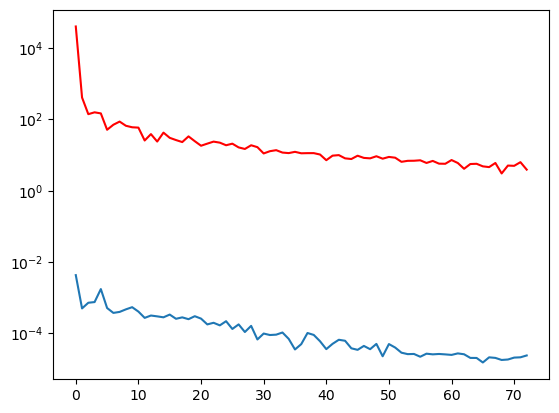

In [53]:
# plot the power spectrum of out_fft and target_fft

plt.plot(out_fft, color='red')
plt.plot(target_fft)

# log scale
plt.yscale('log')

plt.show()

In [49]:
out_fft

tensor([4.0731e+04, 4.1054e+02, 1.4005e+02, 1.5772e+02, 1.4708e+02, 5.1051e+01,
        7.0610e+01, 8.6617e+01, 6.6107e+01, 5.9968e+01, 5.8601e+01, 2.5502e+01,
        3.8512e+01, 2.3793e+01, 4.2384e+01, 3.0300e+01, 2.6215e+01, 2.3022e+01,
        3.3250e+01, 2.4370e+01, 1.8161e+01, 2.0801e+01, 2.3705e+01, 2.2157e+01,
        1.8735e+01, 2.0759e+01, 1.6305e+01, 1.4738e+01, 1.8721e+01, 1.6564e+01,
        1.1029e+01, 1.2759e+01, 1.3630e+01, 1.1671e+01, 1.1279e+01, 1.2240e+01,
        1.1141e+01, 1.1245e+01, 1.1254e+01, 1.0287e+01, 7.1273e+00, 9.5578e+00,
        9.8954e+00, 8.0334e+00, 7.6908e+00, 9.5237e+00, 8.2656e+00, 8.0321e+00,
        9.2017e+00, 7.8607e+00, 8.7997e+00, 8.3749e+00, 6.4165e+00, 6.8406e+00,
        6.8763e+00, 7.0814e+00, 5.9606e+00, 6.8018e+00, 5.6954e+00, 5.6536e+00,
        7.1958e+00, 5.9437e+00, 4.0895e+00, 5.5641e+00, 5.6469e+00, 4.7847e+00,
        4.5573e+00, 5.9517e+00, 3.0230e+00, 5.0308e+00, 4.9503e+00, 6.2708e+00,
        3.8726e+00])

In [50]:
# plot this

freq = torch.fft.fftfreq(data_2d_ts.shape[0])


plt.plot(freq[:int((ts_data.shape[0]/2)]), out_fft[:int((ts_data.shape[0]/2)], label='ts')

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3157472267.py, line 3)

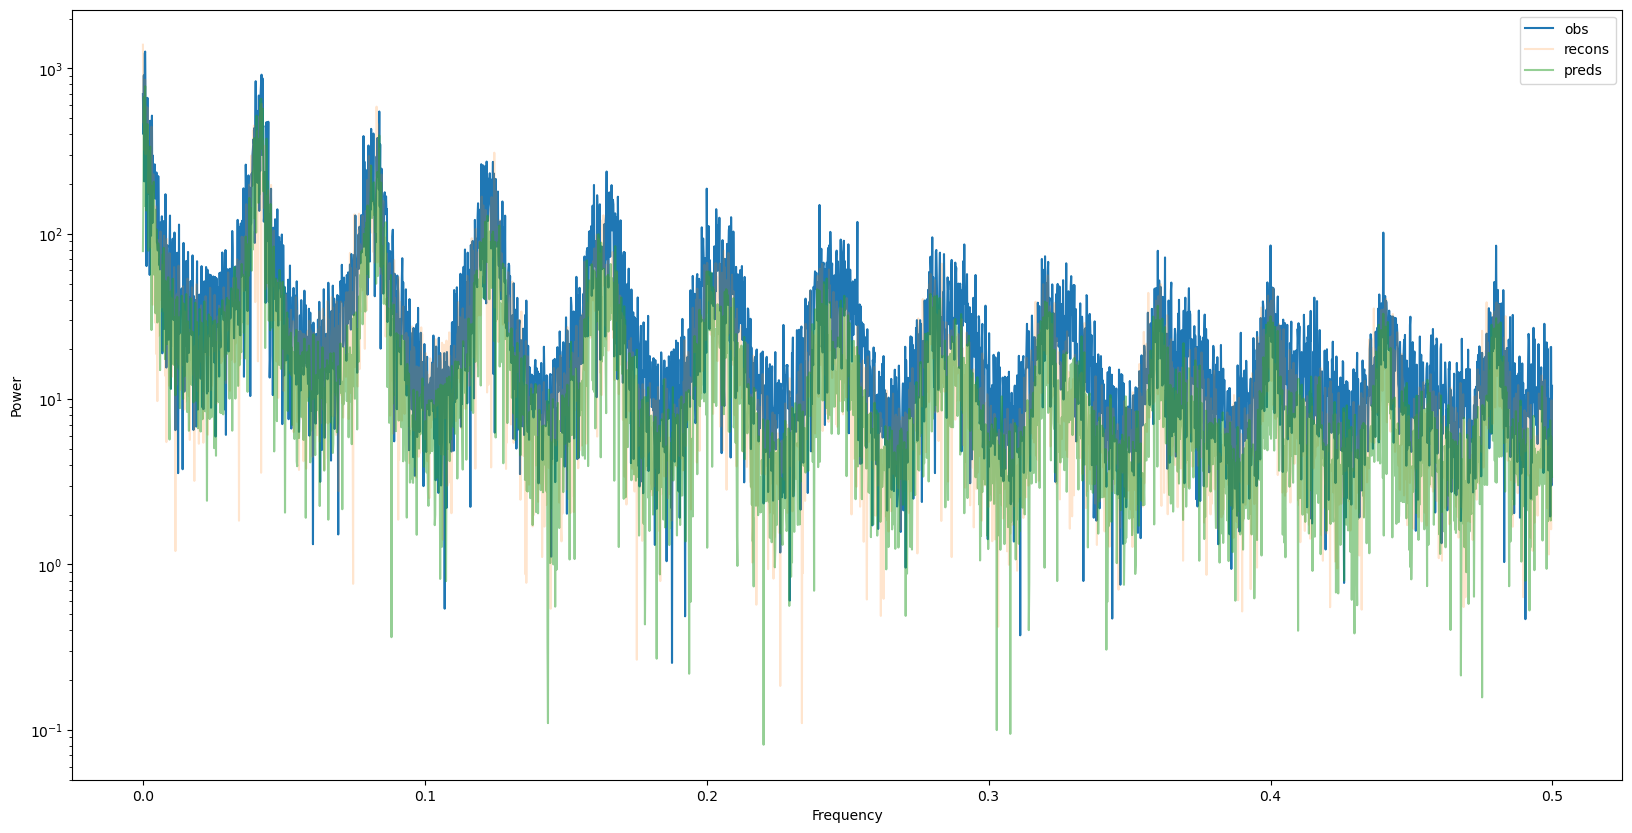

In [17]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 0, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 0, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 0, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

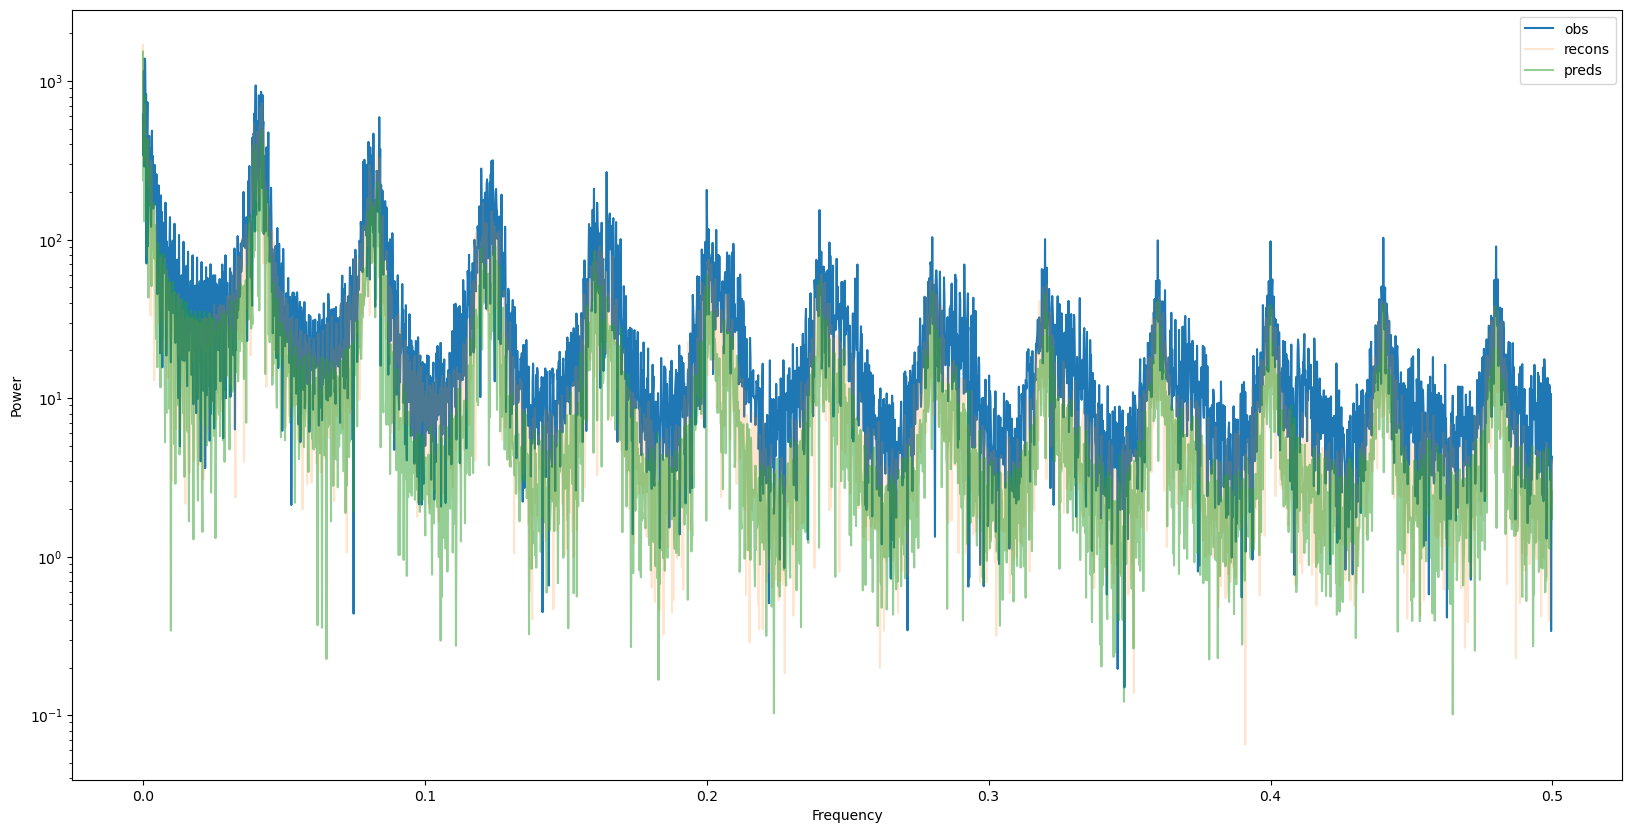

In [18]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 1, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 1, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 1, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])



# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

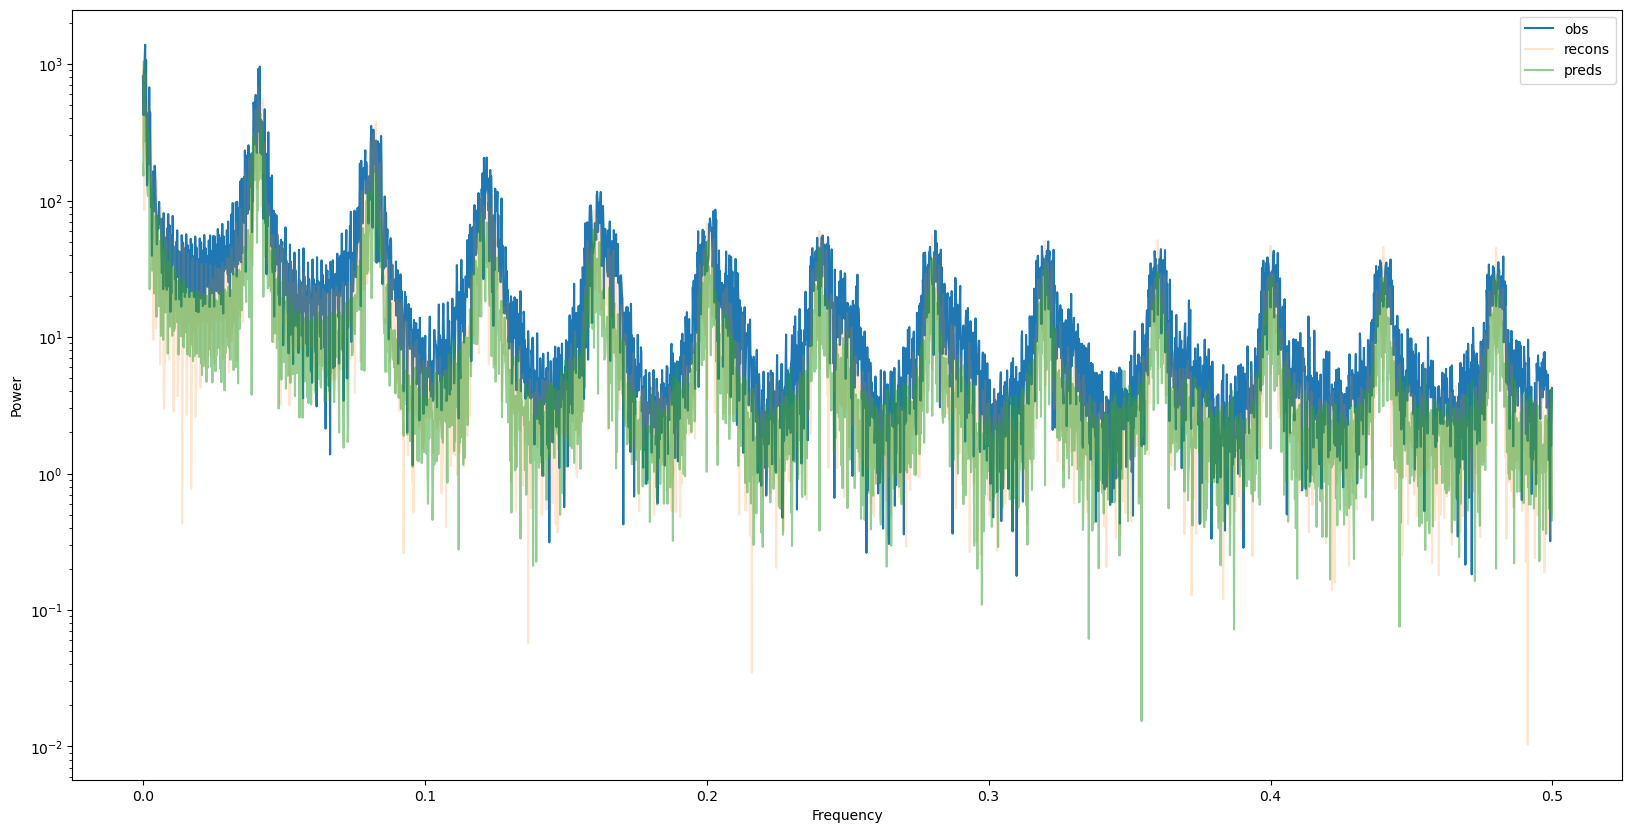

In [12]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 2, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 2, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 2, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

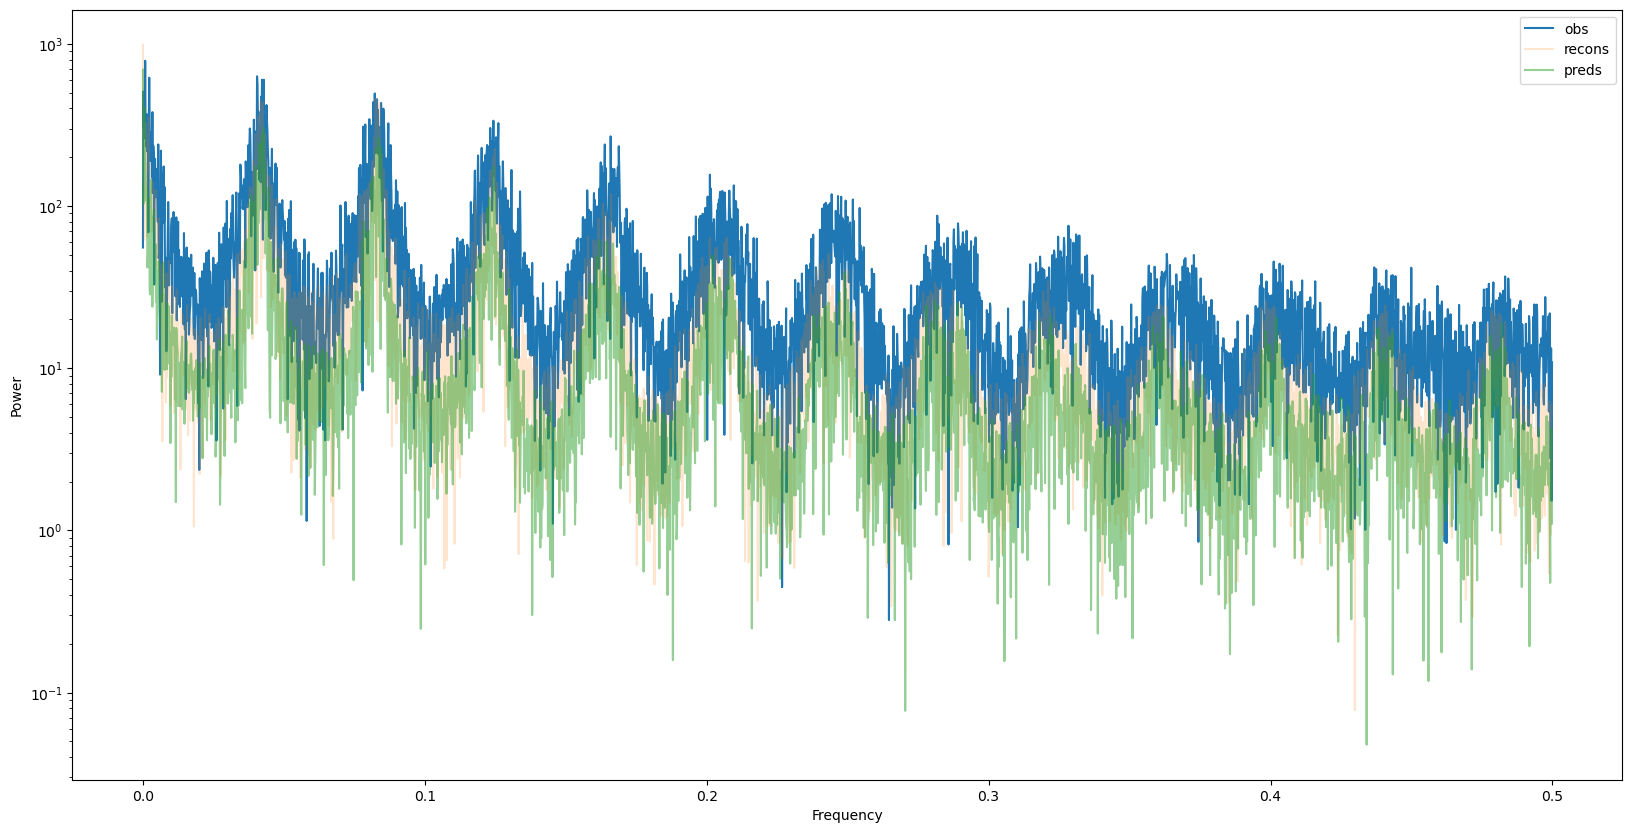

In [20]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big
plt.figure(figsize=(20, 10))

fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 3, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 3, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 3, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [21]:
# calculate the distance between the power spectra

fft_true = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, :, :]), dim=2)), dim=0)
        
# calculate the spectra of the predicted values
fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, :, :]), dim=2)), dim=0)
        
# Calculate the power spectrum
spectral_loss = torch.mean(torch.abs(fft_pred - fft_true))

spectral_loss

tensor(22.7946)

# Do the same for some runs where we have absolutely nailed the spectral loss

10, 100, 1000, 5000, 10000 are the multipliers on the spectral loss that we provide:

In [11]:
obs_x_data_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_x_ar_0.npy")
obs_y_data_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_y_ar_0.npy")
recons_y_data_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/y_pred_recons_train.npy")
pred_y_data_0 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_0/train_y_pred_ar_0.npy")

obs_x_data_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1/train_x_ar_0.npy")
obs_y_data_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1/train_y_ar_0.npy")
recons_y_data_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1/y_pred_recons_train.npy")
pred_y_data_1 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1/train_y_pred_ar_0.npy")

obs_x_data_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_10/train_x_ar_0.npy")
obs_y_data_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_10/train_y_ar_0.npy")
recons_y_data_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_10/y_pred_recons_train.npy")
pred_y_data_10 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_10/train_y_pred_ar_0.npy")

obs_x_data_100 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_100/train_x_ar_0.npy")
obs_y_data_100 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_100/train_y_ar_0.npy")
recons_y_data_100 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_100/y_pred_recons_train.npy")
pred_y_data_100 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_100/train_y_pred_ar_0.npy")

obs_x_data_1000 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1000/train_x_ar_0.npy")
obs_y_data_1000 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1000/train_y_ar_0.npy")
recons_y_data_1000 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1000/y_pred_recons_train.npy")
pred_y_data_1000 = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_1_spcoef_1000/train_y_pred_ar_0.npy")

obs_x_data_10_crps = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_10_spcoef_1/train_x_ar_0.npy")
obs_y_data_10_crps = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_10_spcoef_1/train_y_ar_0.npy")
recons_y_data_10_crps = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_10_spcoef_1/y_pred_recons_train.npy")
pred_y_data_10_crps = np.load("/home/mila/s/sebastian.hickman/scratch/results/test_multigpu_spectral/var_['ts', 'tas', 'psl', 'pr']_scenarios_piControl_tau_3_z_110_lr_0.001_spreg_0.1_ormuinit_100000.0_spmuinit_0.1_spthres_0.5_fixed_False_num_ensembles_1_instantaneous_False_crpscoef_10_spcoef_1/train_y_pred_ar_0.npy")


In [3]:
# write a function to calculate the distance between spectra of two different inputs

def calculate_spectral_loss(obs_y_data, pred_y_data):
    
    fft_true = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, :, :]), dim=2)), dim=0)
        
    # calculate the spectra of the predicted values
    fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, :, :]), dim=2)), dim=0)
        
    # Calculate the power spectrum
    spectral_loss = torch.mean(torch.abs(fft_pred - fft_true))
    
    return spectral_loss

In [15]:
# check if pred_y_data_10 and pred_y_data_100 are the same array

# are they the same?

print((pred_y_data_100 == pred_y_data_1000).all())
print((pred_y_data_10 == pred_y_data_100).all())
print((pred_y_data_0 == pred_y_data_1).all())
print((pred_y_data_0 == pred_y_data_10).all())

# the loss curves look different at least...
print((pred_y_data_10_crps == pred_y_data_10).all())



True
True
True
True
False


In [9]:
obs_y_data_10.shape

(64, 4, 6250)

In [18]:
print(calculate_spectral_loss(obs_y_data_1, pred_y_data_1))
print(calculate_spectral_loss(obs_y_data_10, pred_y_data_10))
print(calculate_spectral_loss(obs_y_data_100, pred_y_data_100))
print(calculate_spectral_loss(obs_y_data_1000, pred_y_data_1000))
print(calculate_spectral_loss(obs_y_data_1000, pred_y_data_1000))
print(calculate_spectral_loss(obs_y_data_10_crps, pred_y_data_10_crps))


tensor(17.9337)
tensor(17.9337)
tensor(17.9337)
tensor(17.9337)
tensor(17.9337)
tensor(16.2459)


In [ ]:
torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, :, :]), dim=2)), dim=0)

In [22]:
obs_y_data_10.shape

(64, 4, 6250)

In [38]:
torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data_10[:, :, :]), dim=2)), dim=0).shape

torch.Size([4, 3126])

In [40]:
torch.mean(torch.fft.rfft(torch.tensor(pred_y_data_10[:, 0, :])), axis=0)

tensor([ 7.0267e+02+0.0000j, -7.2084e+01+75.0724j,  1.9157e+02+31.5314j,
         ...,  6.1406e-01-1.4852j,  2.0537e-02+1.2686j,
         7.3704e-01+0.0000j])

In [44]:
power_spectrum_pred

# take the log of this 

torch.log(power_spectrum_pred).max()

tensor(6.5549)

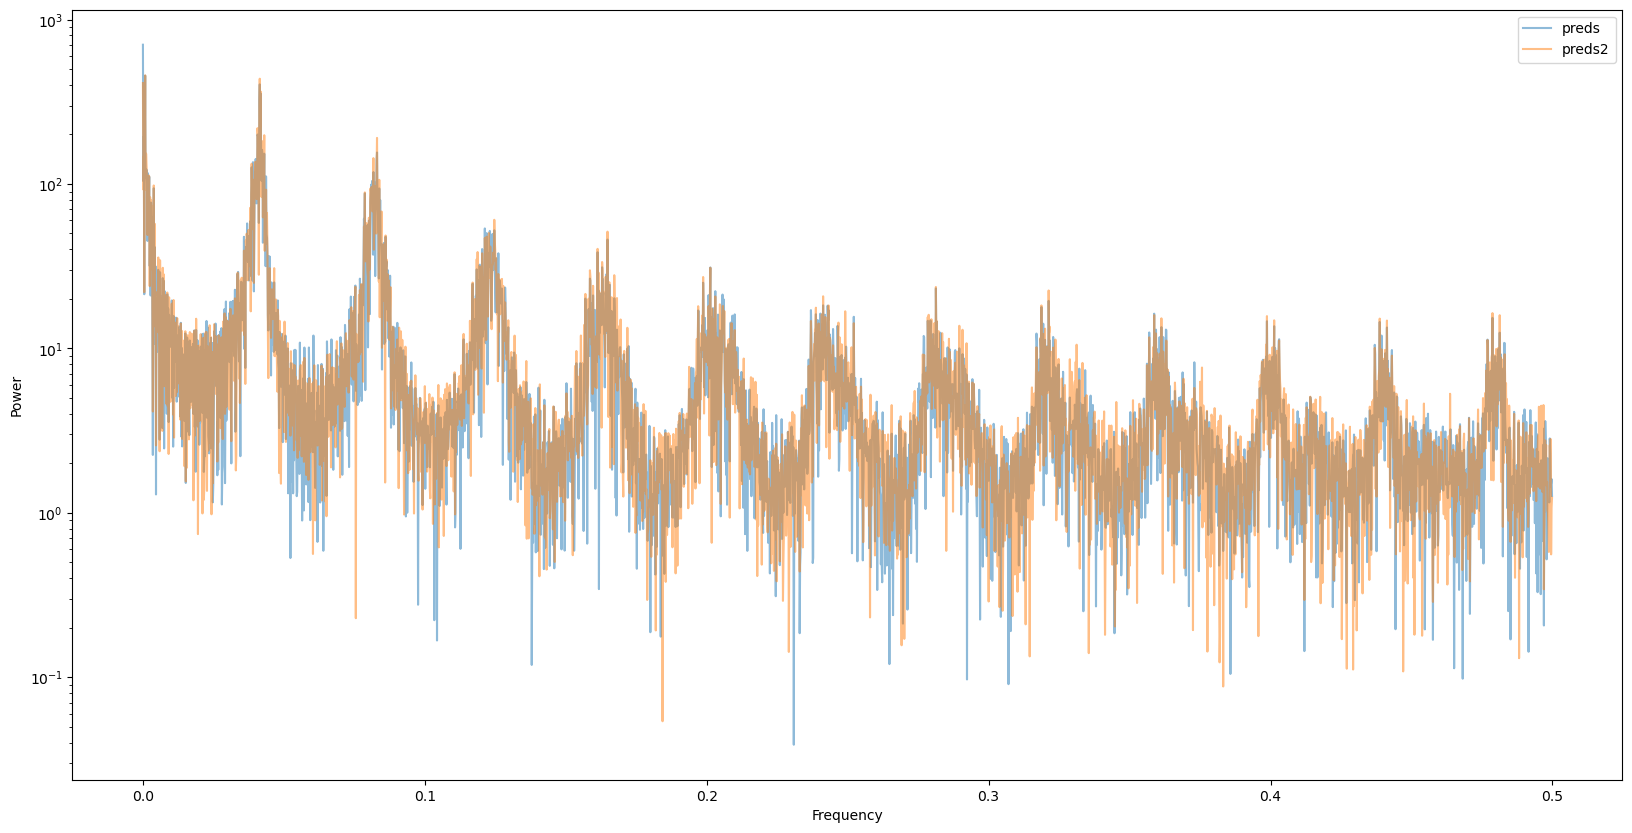

In [35]:
plt.figure(figsize=(20, 10))

fft_result_obs = torch.mean(torch.fft.rfft(torch.tensor(obs_y_data_10[:, 0, :])), axis=0)
#fft_result_obs2 = torch.mean(torch.fft.rfft(torch.tensor(obs_y_data_10_crps[:, 0, :])), axis=0)

fft_result_pred = torch.mean(torch.fft.rfft(torch.tensor(pred_y_data_10[:, 0, :])), axis=0)
fft_result_pred_crps = torch.mean(torch.fft.rfft(torch.tensor(pred_y_data_10_crps[:, 0, :])), axis=0)


# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
#power_spectrum_obs2 = fft_result_obs2.abs()

# see if these two are the same
#print((power_spectrum_obs == power_spectrum_obs2).all())

power_spectrum_pred = fft_result_pred.abs()
power_spectrum_pred_crps = fft_result_pred_crps.abs()


# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data_10.shape[2])

# Plot the power spectrum

#plt.plot(freq[:int((obs_y_data_10[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data_10[0, 0, :].shape[0]/2))], label='obs')

#plt.plot(freq[:int((obs_y_data_10_crps[0, 0, :].shape[0]/2))], power_spectrum_obs2[:int((obs_y_data_10_crps[0, 0, :].shape[0]/2))], label='obs2')

plt.plot(freq[:int((pred_y_data_10[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((pred_y_data_10[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)
plt.plot(freq[:int((pred_y_data_10_crps[0, 0, :].shape[0]/2))], power_spectrum_pred_crps[:int((pred_y_data_10_crps[0, 0, :].shape[0]/2))], label='preds2', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [33]:
# take the mean of the power spectrum
power_spectrum_pred.mean(), power_spectrum_pred_crps.mean()


(tensor(8.3140), tensor(8.5384))

In [19]:
# plot the power spectra

def plot_power_spectra(obs_y_data, pred_y_data, var_index):
    
    # Calculate the Fourier Transform

    # make the figure really big

    plt.figure(figsize=(20, 10))

    fft_result_obs = torch.mean(torch.fft.rfft(torch.tensor(obs_y_data[:, var_index, :])), axis=0)
    fft_result_pred = torch.mean(torch.fft.rfft(torch.tensor(pred_y_data[:, var_index, :])), axis=0)

    # Calculate the power spectrum
    power_spectrum_obs = fft_result_obs.abs()
    power_spectrum_pred = fft_result_pred.abs()

    # Obtain frequency bins
    freq = torch.fft.fftfreq(obs_y_data.shape[2])

    # Plot the power spectrum
    plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, var_index, :].shape[0]/2))], label='obs')

    plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, var_index, :].shape[0]/2))], label='preds', alpha=0.5)


    plt.xlabel('Frequency')
    plt.ylabel('Power')

    # fix the y axis
    plt.yscale('log')

    plt.legend()

    plt.show()

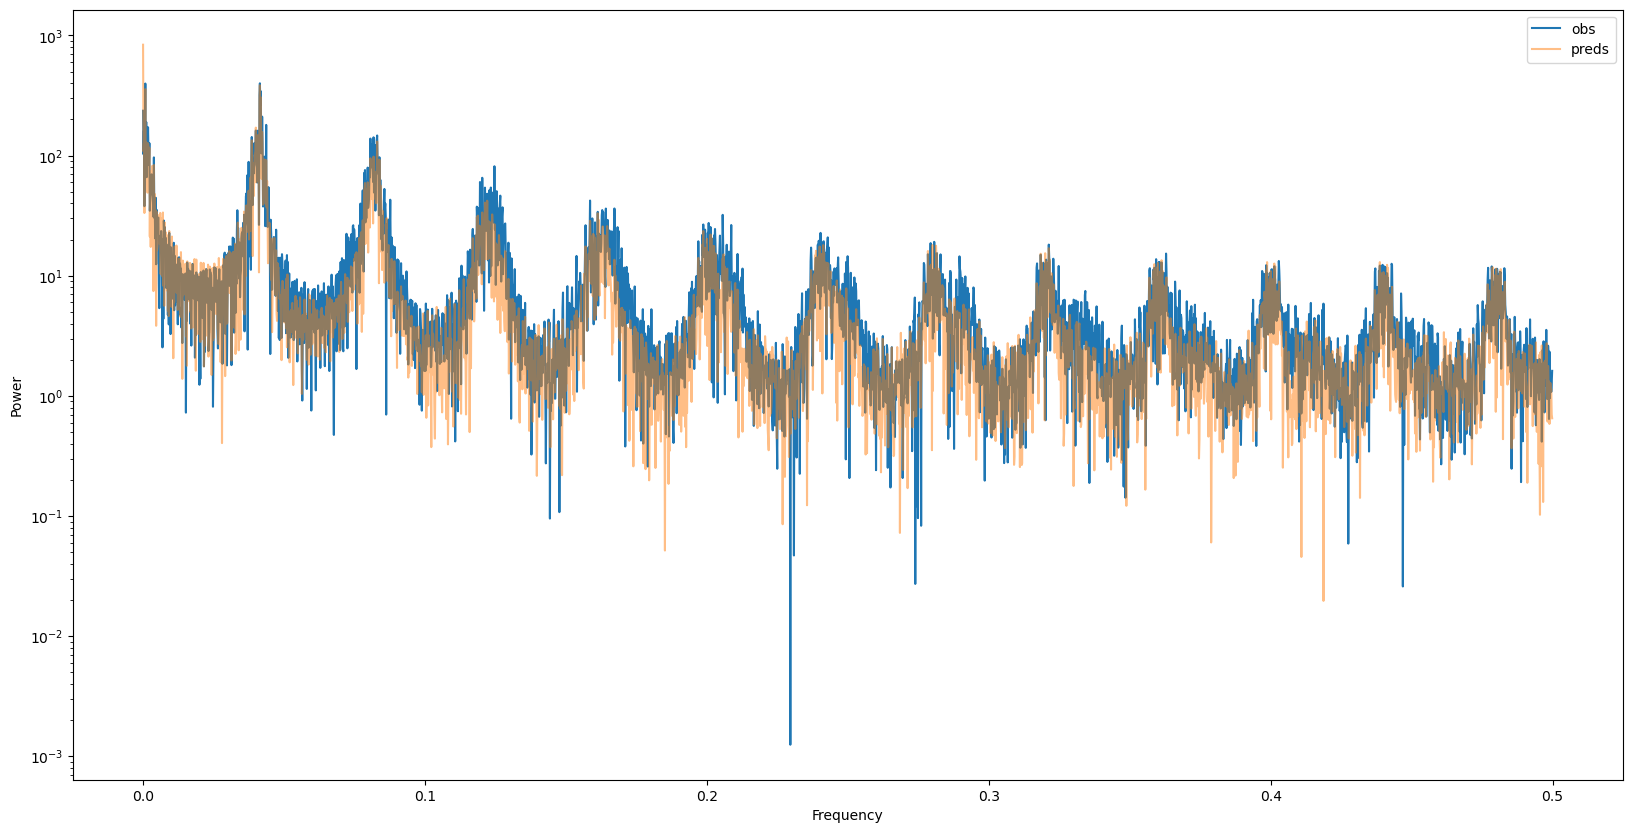

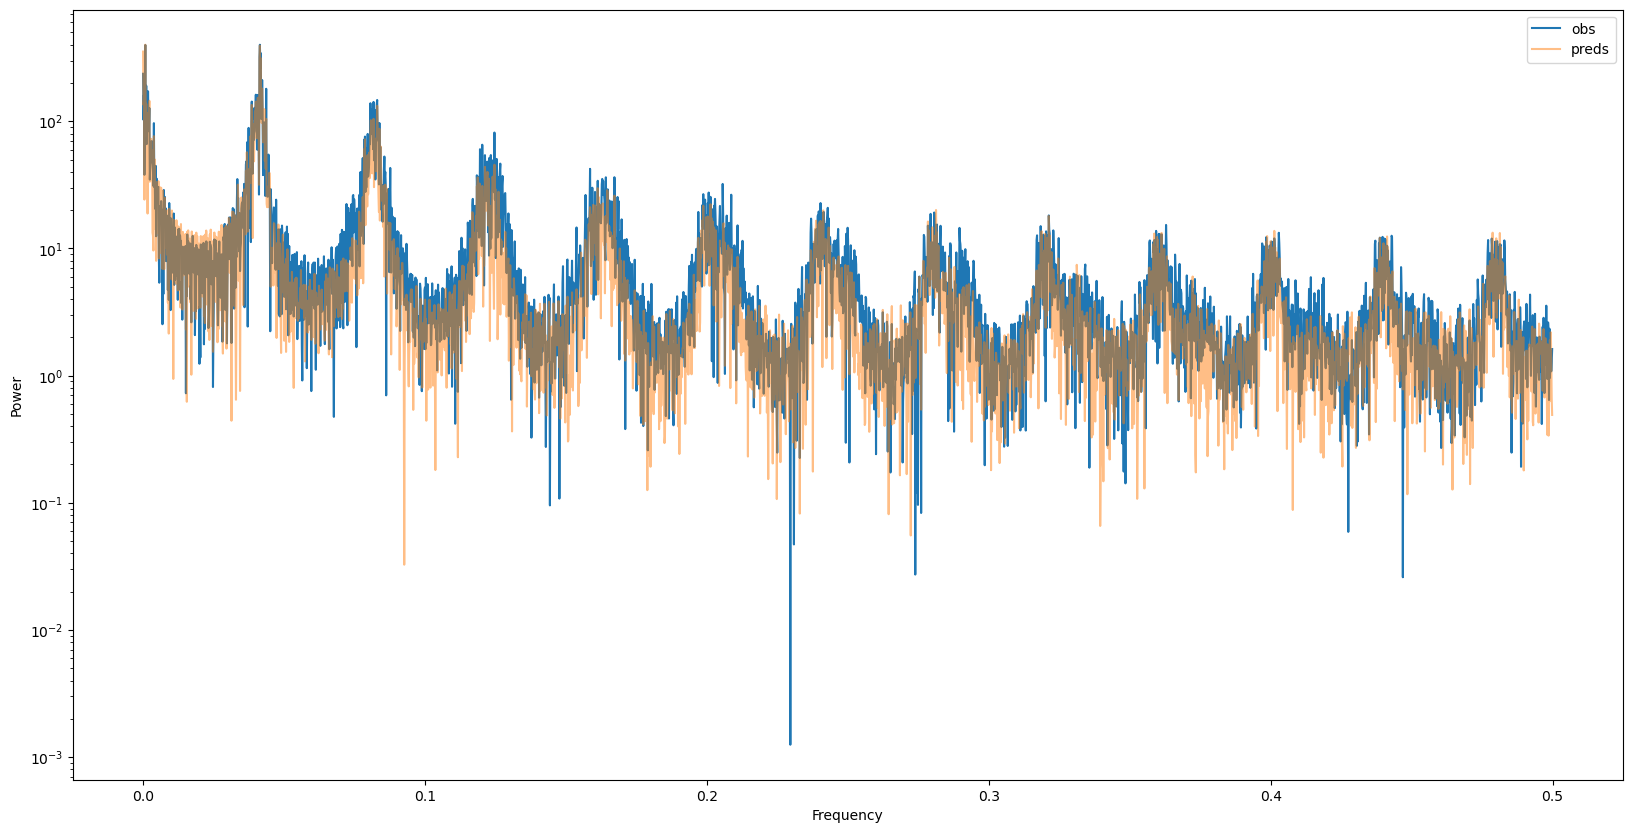

In [21]:
plot_power_spectra(obs_y_data_10, pred_y_data_10, 1)
plot_power_spectra(obs_y_data_10_crps, pred_y_data_10_crps, 1)

In [22]:
torch.abs(torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data_100[:, :, :]), dim=2)), dim=0) - torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data_10000[:, :, :]), dim=2)), dim=0))

tensor([[1.9527e+01, 1.1519e+00, 2.9669e+01,  ..., 2.4315e+00, 1.6205e+00,
         2.3377e+00],
        [9.5312e+01, 2.2546e+01, 1.5927e+01,  ..., 7.1906e-02, 7.1501e-03,
         5.3360e-01],
        [9.4012e+01, 3.5878e+01, 5.0204e+01,  ..., 4.0128e-02, 8.8600e-03,
         3.4842e-01],
        [1.2415e-01, 4.3480e+00, 3.6717e+00,  ..., 2.3183e-01, 9.0150e-01,
         6.3873e-01]])

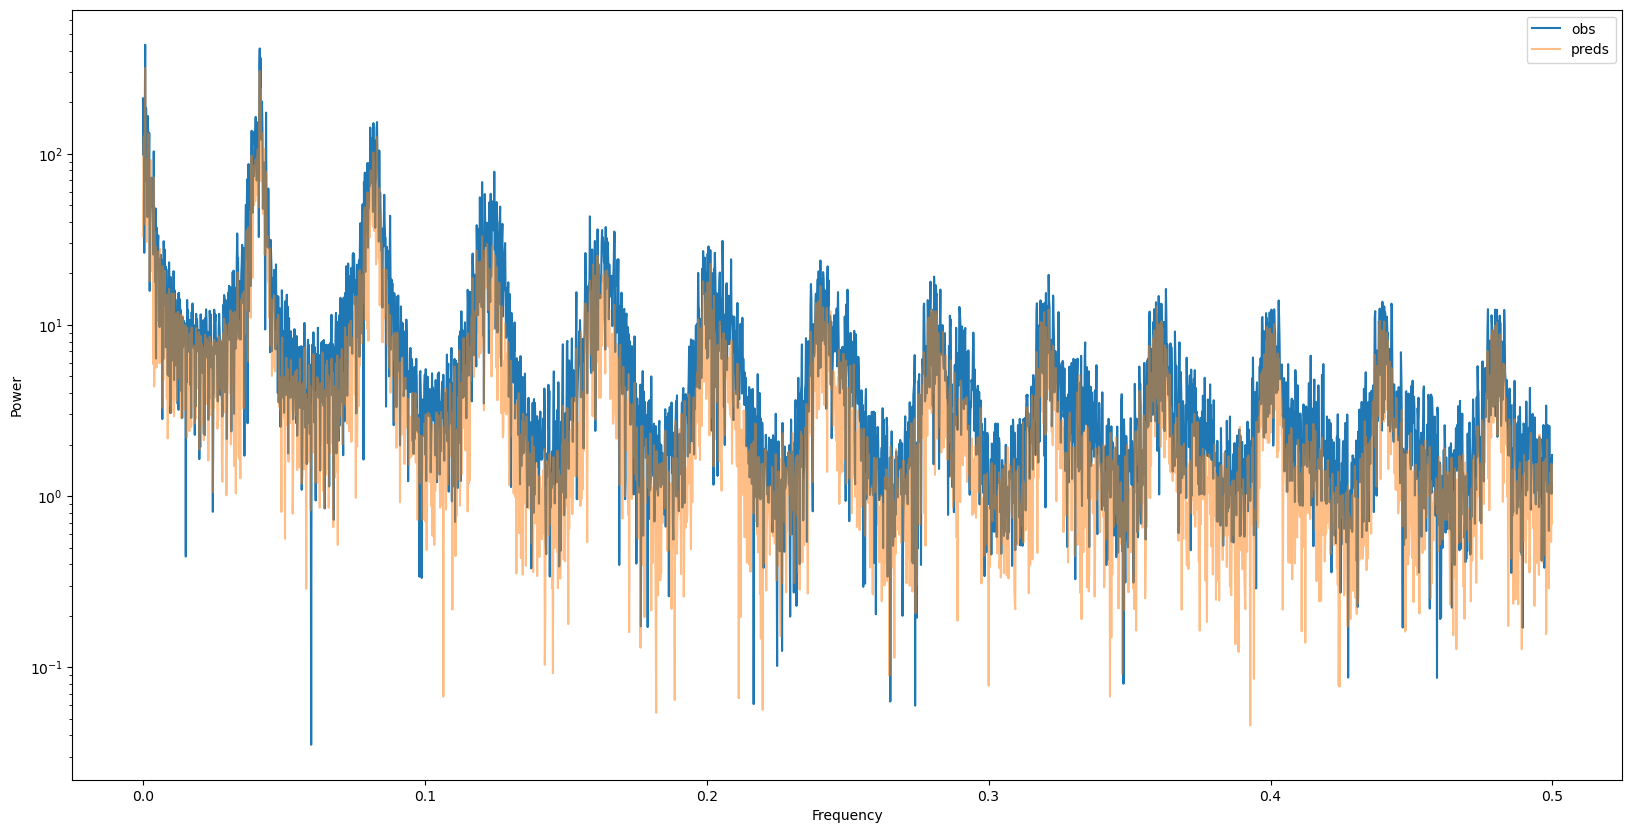

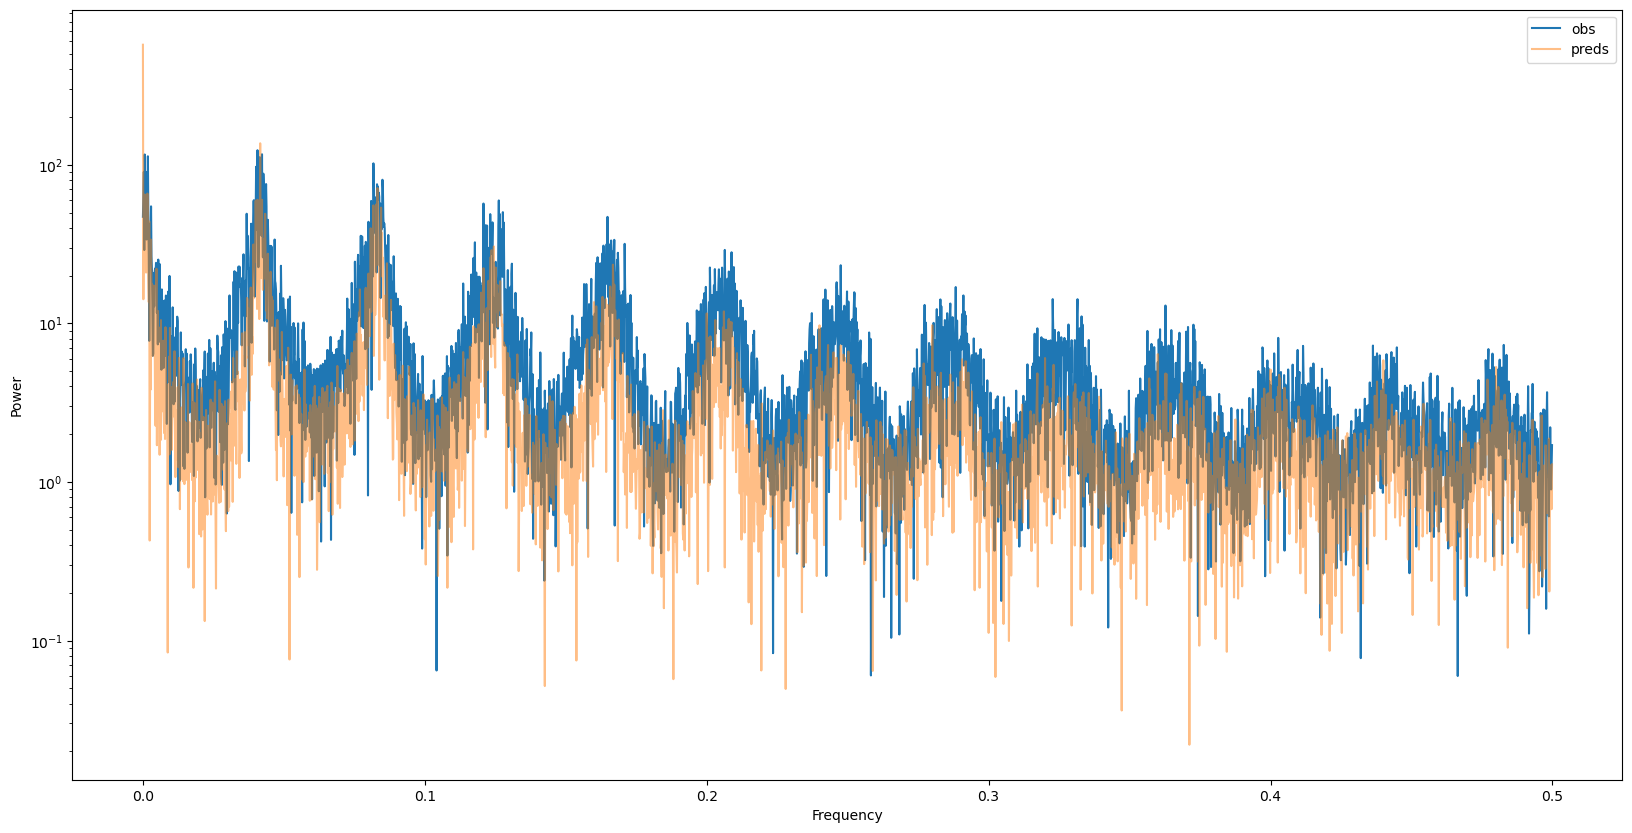

In [15]:
plot_power_spectra(obs_y_data_100, pred_y_data_100, 1)
plot_power_spectra(obs_y_data_100, pred_y_data_100, 3)

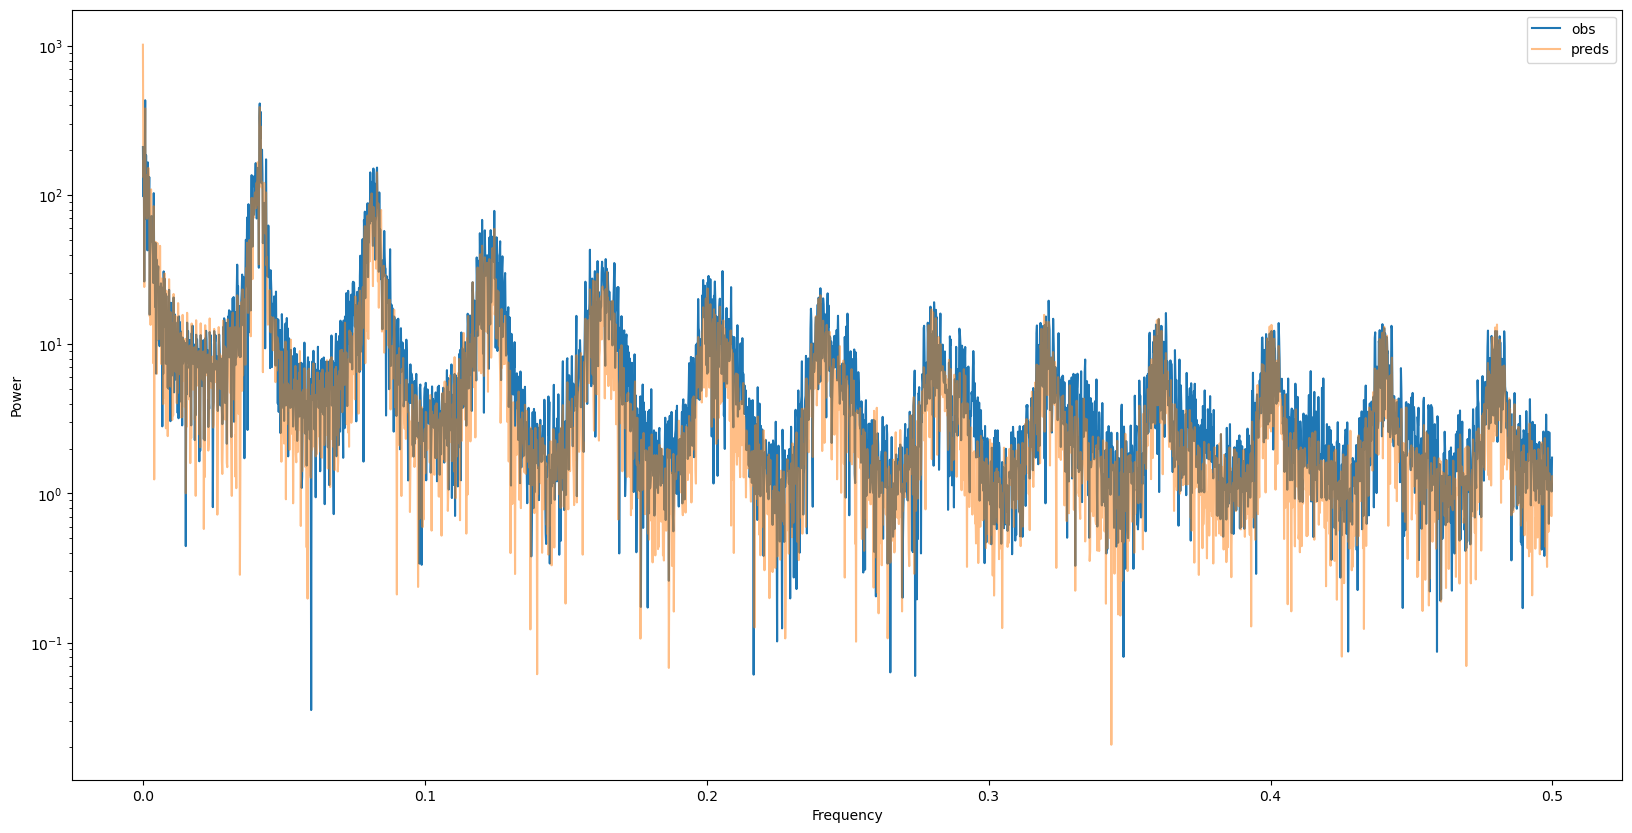

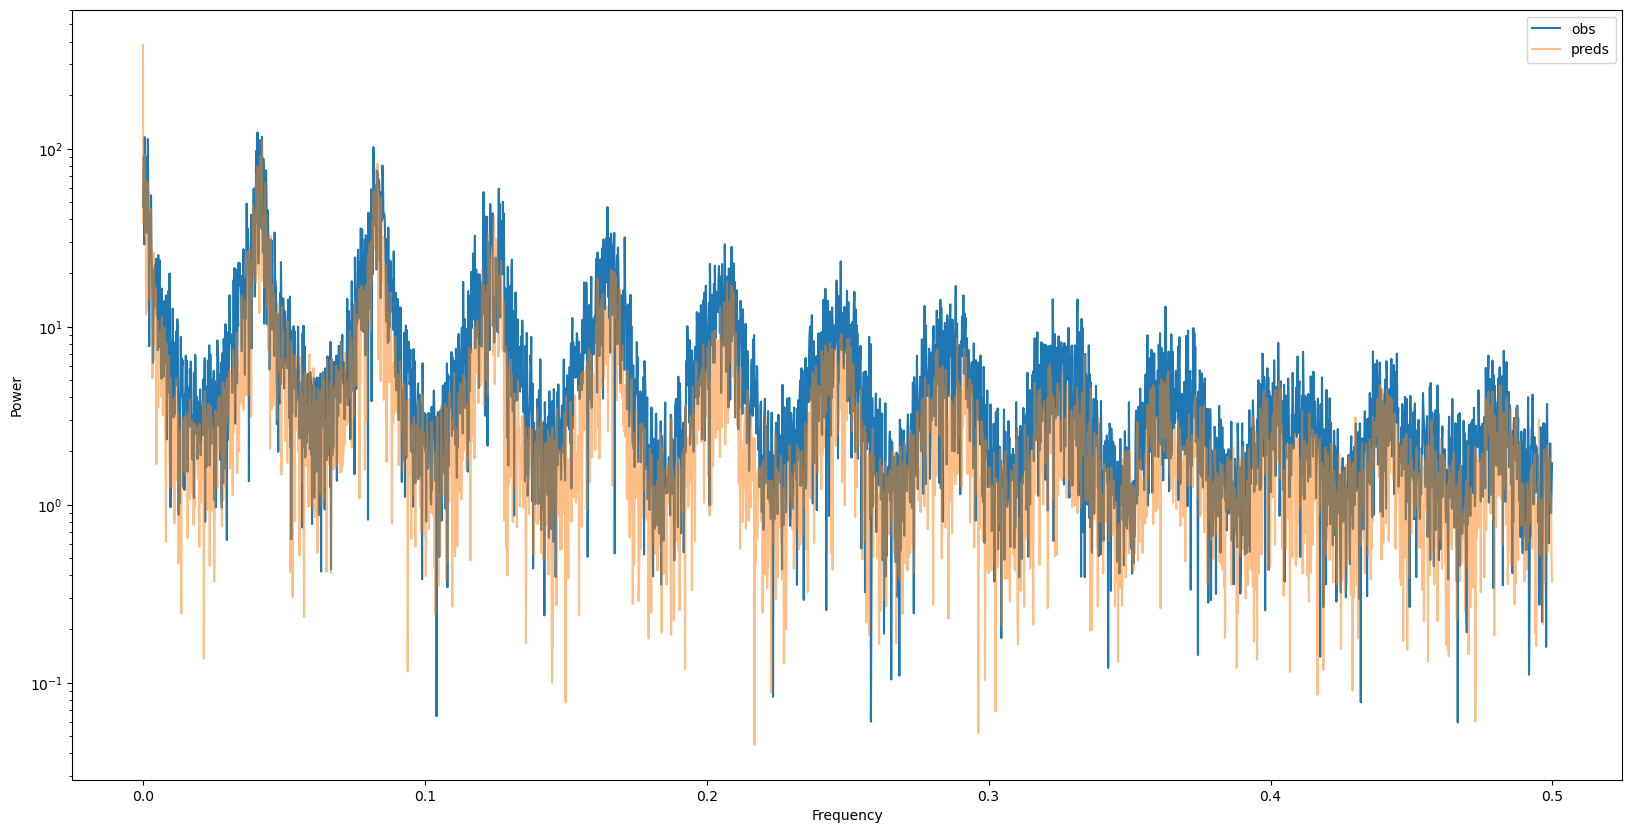

In [10]:
plot_power_spectra(obs_y_data_1000, pred_y_data_1000, 1)
plot_power_spectra(obs_y_data_1000, pred_y_data_1000, 3)

In [58]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.mean(torch.fft.rfft(torch.tensor(obs_y_data[:, 0, :])), axis=0)
fft_result_recons = torch.mean(torch.fft.rfft(torch.tensor(recons_y_data[:, 0, :])), axis=0)
fft_result_pred = torch.mean(torch.fft.rfft(torch.tensor(pred_y_data[0, 0, :])), axis=0)

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

IndexError: slice() cannot be applied to a 0-dim tensor.

<Figure size 2000x1000 with 0 Axes>

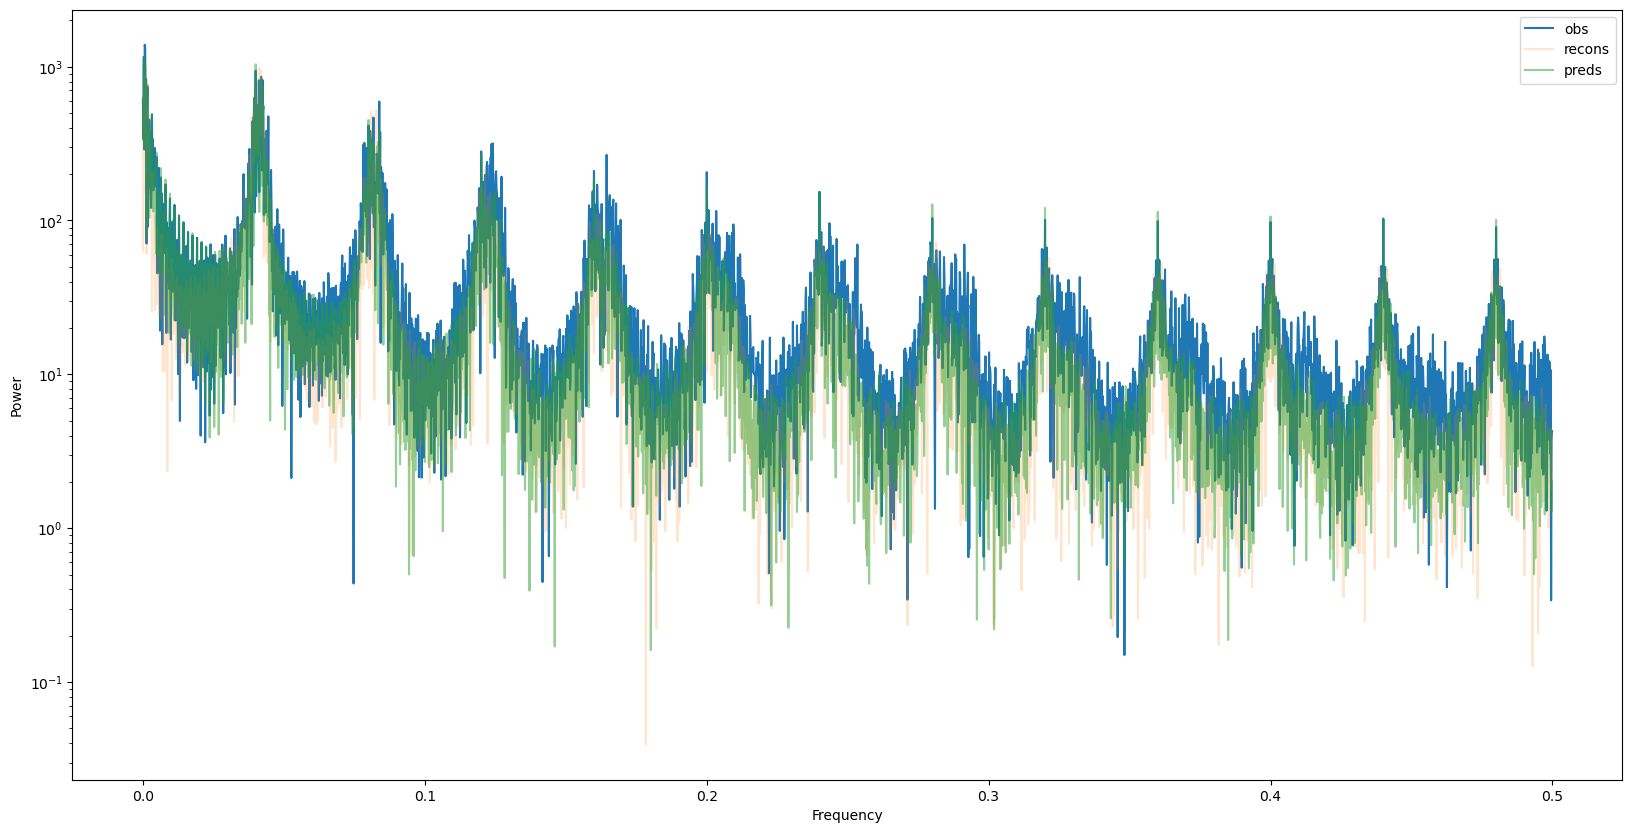

In [26]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 1, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 1, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 1, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 1, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 1, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 1, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [28]:
obs_y_data.shape

(64, 4, 6250)

In [32]:
power_spectrum_obs.shape


torch.Size([3126])

In [35]:
power_spectrum_obs.shape

torch.Size([3126])

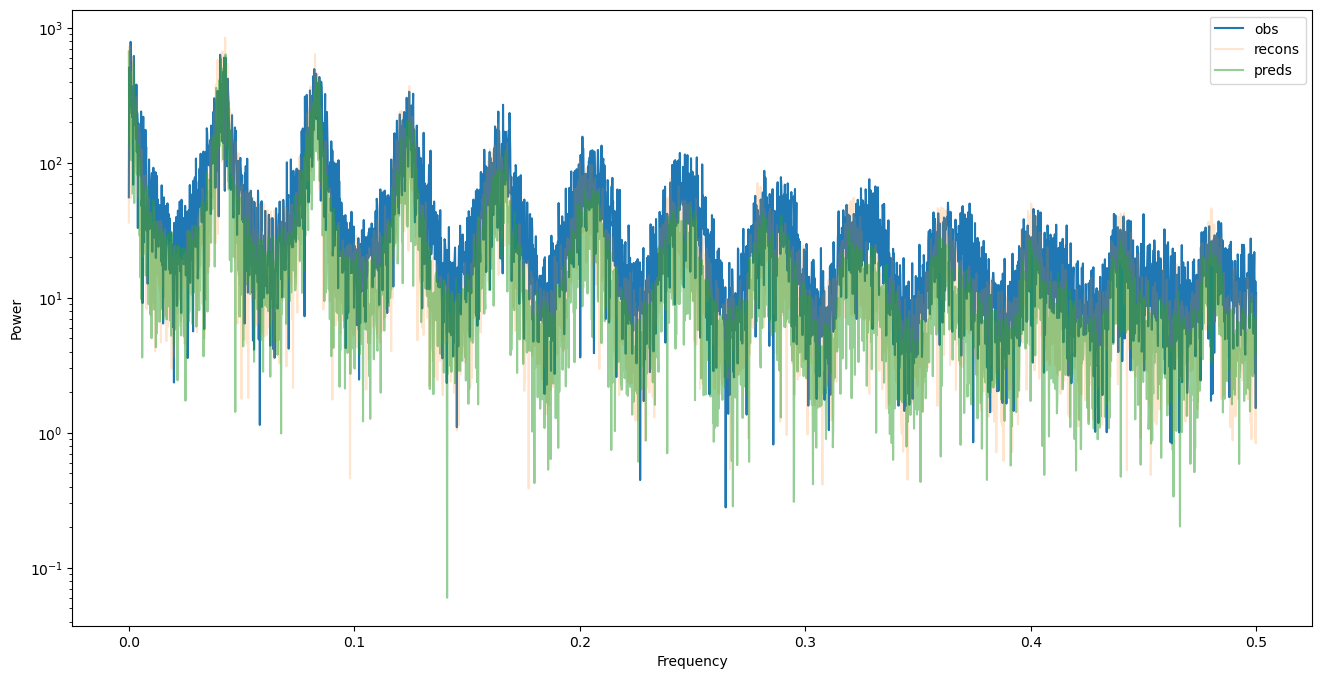

In [36]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(16, 8))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 3, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 3, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 3, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 3, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 3, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 3, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

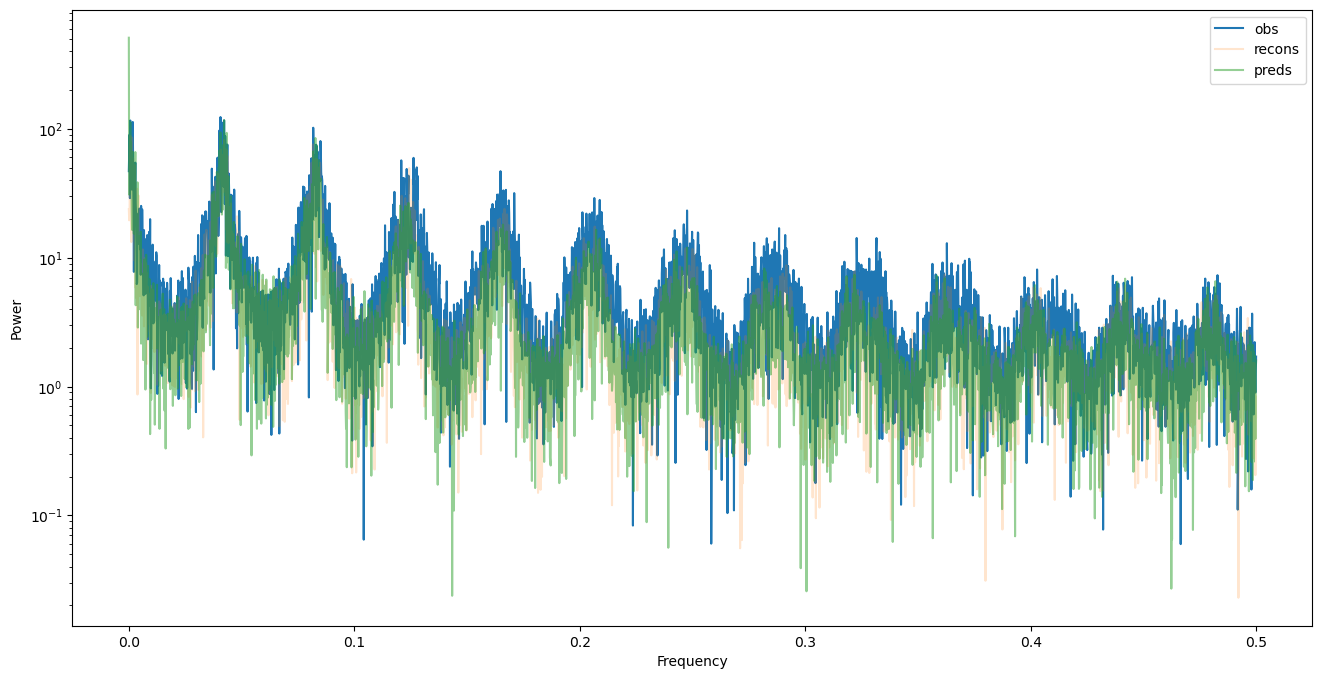

In [37]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(16, 8))


fft_result_obs = torch.mean(torch.fft.rfft(torch.tensor(obs_y_data[:, 3, :])), axis=0)
fft_result_recons = torch.mean(torch.fft.rfft(torch.tensor(recons_y_data[:, 3, :])), axis=0)
fft_result_pred = torch.mean(torch.fft.rfft(torch.tensor(pred_y_data[:, 3, :])), axis=0)

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 3, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 3, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 3, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [ ]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result_obs = torch.fft.rfft(torch.tensor(obs_y_data[0, 0, :]))
fft_result_recons = torch.fft.rfft(torch.tensor(recons_y_data[0, 0, :]))
fft_result_pred = torch.fft.rfft(torch.tensor(pred_y_data[0, 0, :]))

# Calculate the power spectrum
power_spectrum_obs = fft_result_obs.abs()
power_spectrum_recons = fft_result_recons.abs()
power_spectrum_pred = fft_result_pred.abs()

# Obtain frequency bins
freq = torch.fft.fftfreq(obs_y_data.shape[2])

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_obs[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_recons[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], power_spectrum_pred[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

In [117]:
# Ok let's do the FFT on the observations

# Calculate the Fourier Transform

# make the figure really big

plt.figure(figsize=(20, 10))


fft_result = torch.fft.rfft(torch.tensor(obs_y_data[:, 0, :]))
power_spectrum = fft_result.abs()**2

freq = torch.fft.fftfreq(obs_y_data.shape[2])

print(freq.shape)
print(power_spectrum.shape)

TypeError: fft_fftfreq(): argument 'n' (position 1) must be int, not numpy.ndarray

<Figure size 2000x1000 with 0 Axes>

In [131]:
torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, 0, :]), dim=1)), dim=0).shape

torch.Size([3126])

In [142]:
torch.mean(torch.abs(torch.fft.rfft(torch.tensor(recons_y_data[:, :, :]), dim=2)), dim=0).shape
torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, :, :]), dim=2)), dim=0).shape

torch.Size([1, 3126])

In [150]:
fft_true = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, :, :]), dim=2)), dim=0)

In [151]:
fft_pred = torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, :, :]), dim=2)), dim=0)

tensor([[524.7591, 326.1035, 414.5853,  ...,   6.5044,   3.0436,   5.1198]])

In [161]:
torch.mean(((fft_true - fft_pred)**2))

tensor(1000.5967)

In [155]:
spectral_loss = torch.mean((fft_true - fft_pred)**2)

spectral_loss

tensor(1000.5967)

torch.Size([6250])


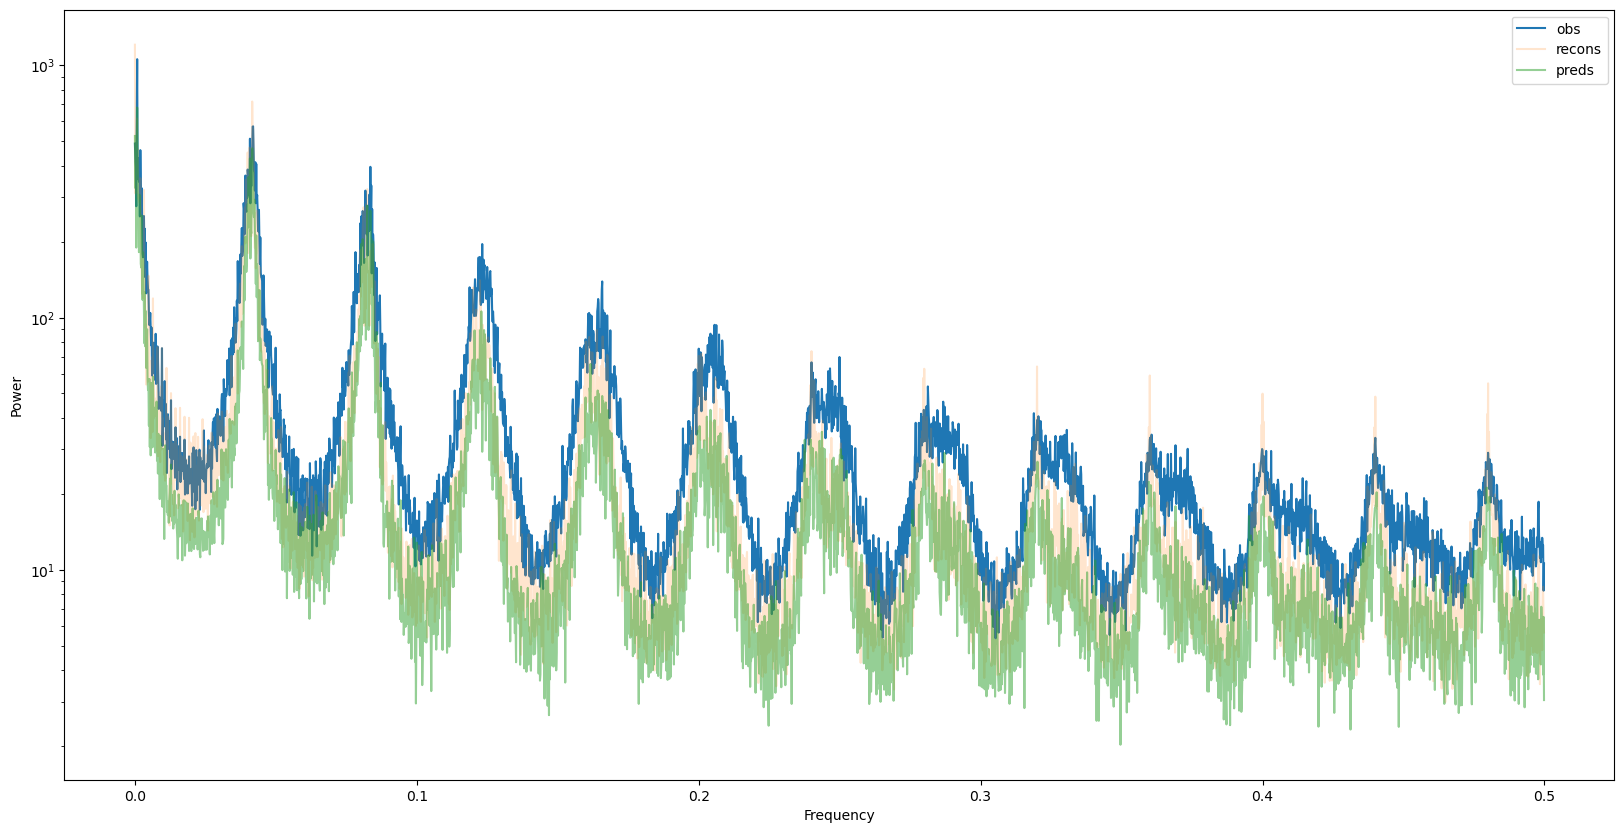

In [148]:
# Calculate the power spectrum
#power_spectrum = fft_result.abs()**2

# Obtain frequency bins
#freq = torch.fft.fftfreq(obs_y_data.shape[2])

plt.figure(figsize=(20, 10))


print(freq.shape)

# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], torch.mean(torch.abs(torch.fft.rfft(torch.tensor(obs_y_data[:, 0, :]), dim=1)), dim=0)[:int((obs_y_data[0, 0, :].shape[0]/2))], label='obs')

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], torch.mean(torch.abs(torch.fft.rfft(torch.tensor(recons_y_data[:, 0, :]), dim=1)), dim=0)[:int((obs_y_data[0, 0, :].shape[0]/2))], label='recons', alpha=0.2)

plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], torch.mean(torch.abs(torch.fft.rfft(torch.tensor(pred_y_data[:, 0, :]), dim=1)), dim=0)[:int((obs_y_data[0, 0, :].shape[0]/2))], label='preds', alpha=0.5)


plt.xlabel('Frequency')
plt.ylabel('Power')

# fix the y axis
plt.yscale('log')

plt.legend()

plt.show()

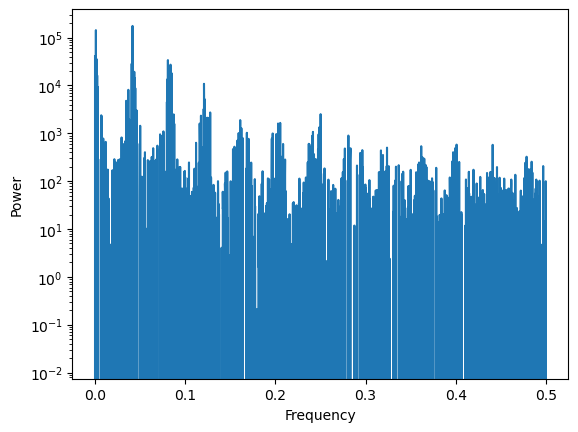

In [101]:
# Plot the power spectrum
plt.plot(freq[:int((obs_y_data[0, 0, :].shape[0]/2))], (power_spectrum_pred - power_spectrum)[:int((obs_y_data[0, 0, :].shape[0]/2))])
plt.xlabel('Frequency')
plt.ylabel('Power')

plt.yscale('log')

plt.show()

In [72]:
power_spectrum_pred - power_spectrum

tensor([ 4.0641e+04, -6.5180e+04, -4.2086e+05,  ...,  9.9836e+01,
        -1.2995e+02, -8.0445e+01])

In [73]:
# caluclate the mean of this:

(power_spectrum_pred - power_spectrum).mean()

tensor(-4246.9790)

In [75]:
# calculate the sum of the power spectrum

power_spectrum_pred.sum()

tensor(8883901.)

In [74]:
# calculate the mean of the absolute difference between the two:

(power_spectrum_pred - power_spectrum).abs().mean()

tensor(4813.6841)